In [115]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from tsfresh import feature_extraction
%matplotlib inline
#import FATS
from sklearn.grid_search import GridSearchCV

In [116]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    
    """
    y - ряд
    lags - количество отрезков на графиках корреляций

    """
    
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        ts_ax.set_xlabel(df.index.name)
        ts_ax.set_ylabel(df.columns[0])
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера")
        result = sm.tsa.stattools.adfuller(y)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
                


        plt.tight_layout()
    return 

# усредним прошлые значения

def moving_average(data, n):
    return np.average(data[-n:])

def plotMovingAverage(data, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = data.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(data[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xlabel(df.index.name)
    plt.ylabel(df.columns[0])
    
    MSE_MA = mean_squared_error(data[(n-1):], data.rolling(window=n).mean()[(n-1):])
    
    print('MSE = ', MSE_MA)
    
# затра будет, как вчера

def plotLag(data):
    
    lag_data = data.shift(periods=1)
    
    plt.figure(figsize=(15,5))
    plt.title("Tomorrow as yesterday predictions")
    plt.plot(lag_data, "g", label="Lagged values")
    
    plt.plot(data, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xlabel(df.index.name)
    plt.ylabel(df.columns[0])
    
    MSE_lag = mean_squared_error(data[1:], lag_data[1:])
    print('MSE = ', MSE_lag)
    return

### Annual velocity of money, 1869-1970

In [4]:
df = pd.read_csv('Project TS/annual-velocity-of-money-1869-to.csv', index_col=['Year'], parse_dates=['Year'])
df.tail()

Annual velocity of money, 1869 to 1970
Year                                                           
1967                                                       1.72
1968                                                       1.72
1969                                                       1.73
1970                                                       1.73
Annual velocity of money                           1869 to 1970

In [5]:
df.drop(df.index[102], inplace=True)

In [6]:
df['Annual velocity of money, 1869 to 1970'] = df['Annual velocity of money, 1869 to 1970'].astype(float)
df.columns = ['Annual velocity of money']

In [7]:
tsplot(df['Annual velocity of money'], lags=25)

Критерий Дики-Фуллера
ADF Statistic: -3.284241
p-value: 0.015598
Critical Values:
	5%: -2.891
	1%: -3.497
	10%: -2.582


Временной ряд стационарен. В начале есть убывающий тренд, но во второй трети он отсутсвует, поэтому будем работать с тем, что есть!

Построим наивный прогноз, предполагая, что будущее знчение переменной завиист от $n$ её предыдущих значений, следующим образом:

$$\hat{y_t} = \frac{1}{k} \sum_{n=0}^{k-1} y_{t-n},$$

и посчитаем для него среднеквадратичную ошибку.

In [8]:
plotMovingAverage(df['Annual velocity of money'][:'1940'], n=5)

MSE =  0.0508650588235


Построим ещё один прогноз, предполагая, что значенияе завтра будет таким же, как вчера, и посчитаем для него срднеквадратичную ошибку.

MSE =  0.0445563380282


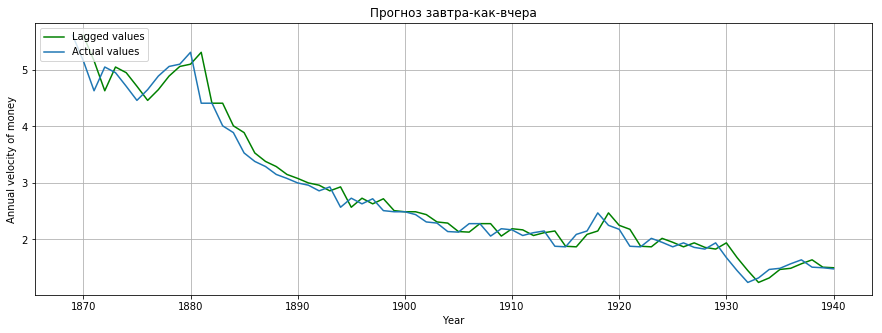

In [9]:
plotLag(df['Annual velocity of money'][:'1940'])

Получили, что в обоих случаях среднеквадратичные ошибки примерно одинаковы и равны $\sim 0.03$, однако этот результат сильно зависит от ширины окна в прогнозе скользящего среднего.

Теперь нужно добавить признаки. Поскольку данные годовые, большинство простых признаков, приходящих в голову первыми, как сезон, день недели, время суток и т.д. здесь не применимы :( Поэтому имеет смысл начать с добавления признака, равного некоторому лагу наблюдений. Здесь попробуем использовать лаги $t-2, t-1$.

In [10]:
temps = pd.DataFrame(df.values)
dataframe = pd.concat([temps.shift(2), temps.shift(1)], axis=1)
dataframe.columns = ['t-2', 't-1']
dataframe.index = df.index
print(dataframe.head(10))

       t-2   t-1
Year            
1869   NaN   NaN
1870   NaN  5.61
1871  5.61  5.16
1872  5.16  4.63
1873  4.63  5.05
1874  5.05  4.95
1875  4.95  4.71
1876  4.71  4.46
1877  4.46  4.65
1878  4.65  4.89


Эту идею можно слегка усложнить, добавив в качестве признака среднее двух предыдущих значений:

In [11]:
temps = pd.DataFrame(df.values)
shifted = temps.shift(1)
window = shifted.rolling(window=2)
means = window.mean()
means.index = df.index
dataframe['mean(t-2,t-1)'] = means
print(dataframe.head(10))

       t-2   t-1  mean(t-2,t-1)
Year                           
1869   NaN   NaN            NaN
1870   NaN  5.61            NaN
1871  5.61  5.16          5.385
1872  5.16  4.63          4.895
1873  4.63  5.05          4.840
1874  5.05  4.95          5.000
1875  4.95  4.71          4.830
1876  4.71  4.46          4.585
1877  4.46  4.65          4.555
1878  4.65  4.89          4.770


Пока параметры у xgboost стоят по дефлоту, разберёмся с ними позже!

In [12]:
gbm = XGBRegressor()
res = gbm.fit(dataframe[:'1940'], df.loc[:'1940'])

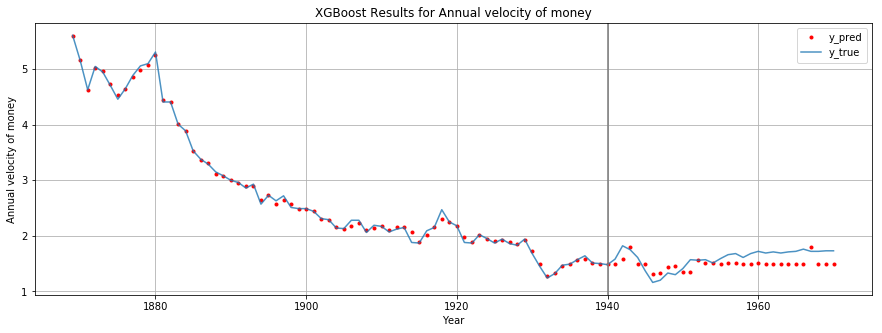

In [13]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe))
y_pred.index = df.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", label="y_pred")
plt.plot(df, alpha=0.8, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x=1940, color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Annual velocity of money')
plt.xlabel('Year')
plt.ylabel('Annual velocity of money')

In [14]:
mse_train = mean_squared_error(df.loc[:'1940'], y_pred[:'1940'])
mse_test = mean_squared_error(df.loc['1940':], y_pred['1940':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.00213172085973
MSE test = 0.02772042124


Получили, что качество прогноза у xgboost значительно лучше на обучающей выборке и лучше на тестовой.

In [15]:
xgb.plot_importance(gbm)

Судя по коррелограмам, предыдщуие значение оказывает влияние на несколько следующих, так что стоит проверить, будут ли лучшими признакими другие количества лагов.

In [16]:
df_features = pd.DataFrame()

for i in range(12,0,-1):
    df_features['t-'+str(i)] = df['Annual velocity of money'].shift(i)
print(df_features.head(13))
dataframe = dataframe[13:]

      t-12  t-11  t-10   t-9   t-8   t-7   t-6   t-5   t-4   t-3   t-2   t-1
Year                                                                        
1869   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1870   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  5.61
1871   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  5.61  5.16
1872   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  5.61  5.16  4.63
1873   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  5.61  5.16  4.63  5.05
1874   NaN   NaN   NaN   NaN   NaN   NaN   NaN  5.61  5.16  4.63  5.05  4.95
1875   NaN   NaN   NaN   NaN   NaN   NaN  5.61  5.16  4.63  5.05  4.95  4.71
1876   NaN   NaN   NaN   NaN   NaN  5.61  5.16  4.63  5.05  4.95  4.71  4.46
1877   NaN   NaN   NaN   NaN  5.61  5.16  4.63  5.05  4.95  4.71  4.46  4.65
1878   NaN   NaN   NaN  5.61  5.16  4.63  5.05  4.95  4.71  4.46  4.65  4.89
1879   NaN   NaN  5.61  5.16  4.63  5.05  4.95  4.71  4.46  4.65  4.89  5.06

In [17]:
gbm = XGBRegressor()
res = gbm.fit(df_features[:'1940'], df['Annual velocity of money'].loc[:'1940'])

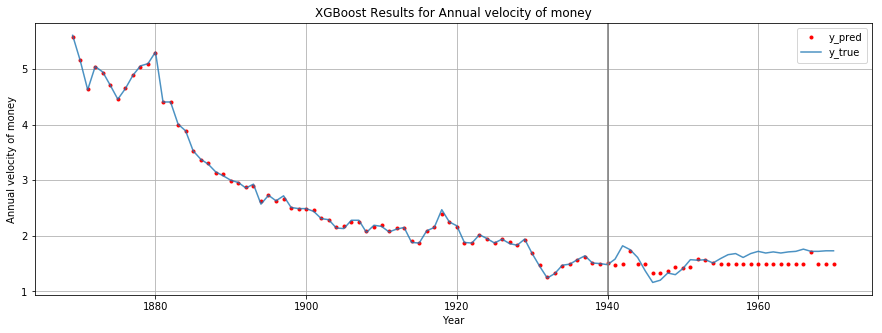

In [18]:
y_pred = pd.DataFrame(data=gbm.predict(df_features))
y_pred.index = df.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", label="y_pred")
plt.plot(df['Annual velocity of money'], alpha=0.8, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x=1940, color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Annual velocity of money')
plt.xlabel('Year')
plt.ylabel('Annual velocity of money')

In [19]:
mse_train = mean_squared_error(df['Annual velocity of money'].loc[:'1940'], y_pred[:'1940'])
mse_test = mean_squared_error(df['Annual velocity of money'].loc['1940':], y_pred['1940':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.000469615673636
MSE test = 0.028064923101


Качество слегка ухудшилось. Посмотрим, какие признаки были самыми значимыми, и обучим модель только на них

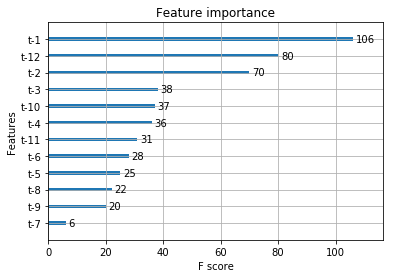

In [20]:
xgb.plot_importance(gbm)

In [21]:
temps = pd.DataFrame(df['Annual velocity of money'].values)
df_best_features = pd.concat([temps.shift(12), temps.shift(1)], axis=1)
df_best_features.columns = ['t-12', 't-1']
df_best_features.index = df['Annual velocity of money'].index
print(df_best_features.head(13))

      t-12   t-1
Year            
1869   NaN   NaN
1870   NaN  5.61
1871   NaN  5.16
1872   NaN  4.63
1873   NaN  5.05
1874   NaN  4.95
1875   NaN  4.71
1876   NaN  4.46
1877   NaN  4.65
1878   NaN  4.89
1879   NaN  5.06
1880   NaN  5.10
1881  5.61  5.31


In [22]:
gbm = XGBRegressor()
res = gbm.fit(df_best_features[:'1940'], df['Annual velocity of money'].loc[:'1940'])

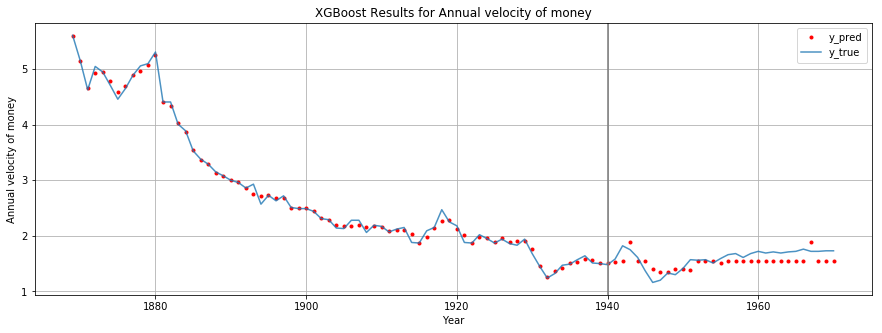

In [23]:
y_pred = pd.DataFrame(data=gbm.predict(df_best_features))
y_pred.index = df.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", label="y_pred")
plt.plot(df['Annual velocity of money'], alpha=0.8, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x=1940, color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Annual velocity of money')
plt.xlabel('Year')
plt.ylabel('Annual velocity of money')

In [24]:
mse_train = mean_squared_error(df['Annual velocity of money'].loc[:'1940'], y_pred[:'1940'])
mse_test = mean_squared_error(df['Annual velocity of money'].loc['1940':], y_pred['1940':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.00380892767966
MSE test = 0.0200606859482


Обобщим результаты:

| Признаки | Качество на обучении | Качество на контроле
| :- |:-: | :-: | :-:
| $t-2 \text{,  } t-1 \text{,   mean}(t-2,t-1)$ | 0.00213 | 0.02772
| $ t-12 \text{  } ... \text{  } t-1$ | __0.00047__ | 0.02806
| $ t-12 \text{,  } t-1$ | 0.00381 | __0.02006__
|  |  |
| Скользящее среднее | 0.05087
| Завтра как вчера  |  0.04456

### Quarterly S&P 500 index, 1900-1996

In [25]:
df = pd.read_csv('Project TS/quarterly-sp-500-index-19001996.csv')
df.tail(5)

Quarter Quarterly S&P 500 index, 1900-1996
384                   1996Q1                              1.559
385                   1996Q2                              1.585
386                   1996Q3                              1.788
387                   1996Q4                              1.817
388  Quarterly S&P 500 index                          1900-1996

In [26]:
df.drop(df.index[388], inplace=True)

In [27]:
date_index = pd.date_range(start='1900', end='1997', freq='Q')
df.index = date_index
df.index.name = 'Year'
df['Q'] = df['Quarter'].map(lambda x: x[-1])
df.drop(inplace=True, labels='Quarter', axis=1)
df.columns = ['S&P 500 index', 'Quarter']
df['S&P 500 index'] =  df['S&P 500 index'].astype(float)
df['Quarter'] = df['Quarter'].astype(int)

In [28]:
df = pd.concat([df, pd.get_dummies(df['Quarter'], columns=['Q1', 'Q2', 'Q3', 'Q4'])], axis=1)

In [29]:
df.drop('Quarter', axis=1, inplace=True)

Критерий Дики-Фуллера
ADF Statistic: -2.286325
p-value: 0.176416
Critical Values:
	5%: -2.869
	1%: -3.448
	10%: -2.571


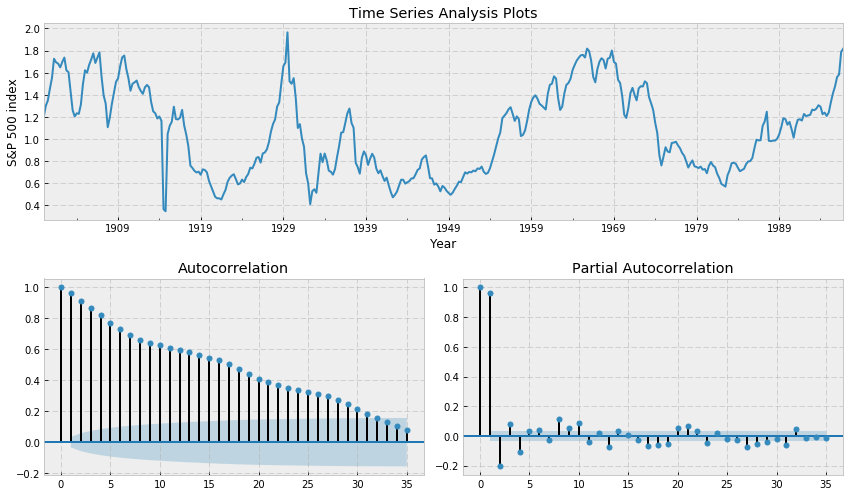

In [30]:
tsplot(df['S&P 500 index'], lags=35)

Ряд нестационарный! Но пока не будем обращать на это внимание, а в конце сделаем его стационарным и посмотрим, как на это реагриует xgboost!

MSE =  0.0387023956364


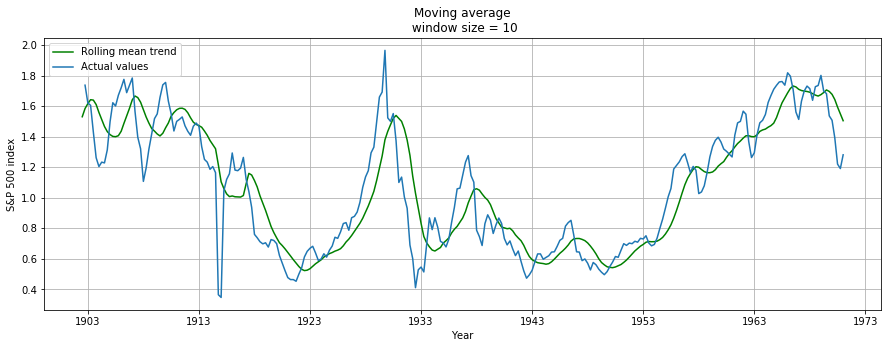

In [31]:
plotMovingAverage(df['S&P 500 index'][:'1970'], n=10)

MSE =  0.0112163250883


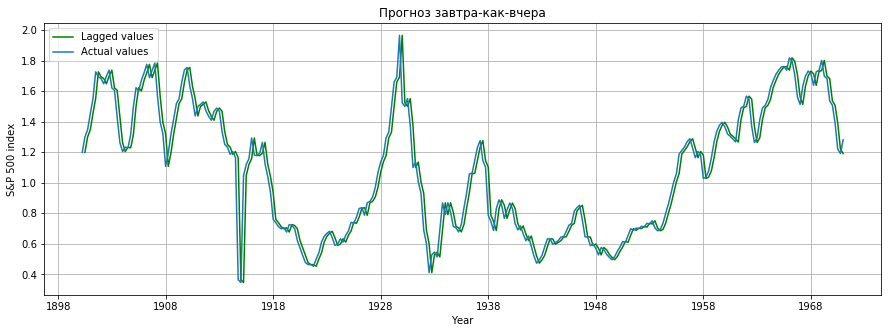

In [32]:
plotLag(df['S&P 500 index'][:'1970'])

Начём с простых признаков, как и в предыдущем анализе. Правда, здесь уже можно закодировать квартал.

In [33]:
temps = pd.DataFrame(df['S&P 500 index'].values)
qua = pd.DataFrame(df[[1, 2, 3, 4]].values)
dataframe = pd.concat([temps.shift(12), temps.shift(1), qua], axis=1)
dataframe.columns = ['t-2', 't-1', 'Q1', 'Q2', 'Q3', 'Q4']
dataframe.index = df.index
print(dataframe.head(10))

            t-2    t-1  Q1  Q2  Q3  Q4
Year                                  
1900-03-31  NaN    NaN   1   0   0   0
1900-06-30  NaN  1.199   0   1   0   0
1900-09-30  NaN  1.300   0   0   1   0
1900-12-31  NaN  1.348   0   0   0   1
1901-03-31  NaN  1.455   1   0   0   0
1901-06-30  NaN  1.552   0   1   0   0
1901-09-30  NaN  1.726   0   0   1   0
1901-12-31  NaN  1.694   0   0   0   1
1902-03-31  NaN  1.682   1   0   0   0
1902-06-30  NaN  1.648   0   1   0   0


In [34]:
df.drop(labels=[1, 2, 3, 4], axis=1, inplace=True)

In [35]:
gbm = XGBRegressor()
res = gbm.fit(dataframe[:'1970'], df.loc[:'1970'])

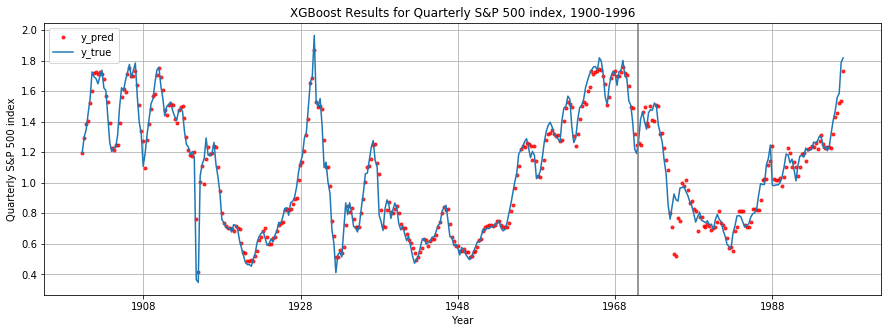

In [36]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe))
y_pred.index = df.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(df, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x='1970-12', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Quarterly S&P 500 index, 1900-1996')
plt.xlabel('Year')
plt.ylabel('Quarterly S&P 500 index')

In [37]:
mse_train = mean_squared_error(df.loc[:'1970'], y_pred[:'1970'])
mse_test = mean_squared_error(df.loc['1970':], y_pred['1970':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.00359075004387
MSE test = 0.00839940290651


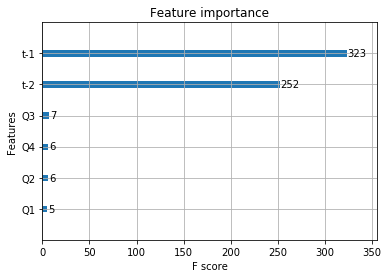

In [38]:
xgb.plot_importance(gbm)

А теперь повторим то же, что и с предыдщуими данными, и настроим модель на лучших лагах (тут наиболее хороший результат достигается при $t-1$, $t-4$, $t-12$):

In [39]:
temps = pd.DataFrame(df['S&P 500 index'].values)
dataframe = pd.concat([temps.shift(12), temps.shift(4), temps.shift(1), qua], axis=1)
dataframe.columns = ['t-12', 't-1', 't-4', 'Q1', 'Q2', 'Q3', 'Q4']
dataframe.index = df.index
print(dataframe.head(13))

             t-12    t-1    t-4  Q1  Q2  Q3  Q4
Year                                           
1900-03-31    NaN    NaN    NaN   1   0   0   0
1900-06-30    NaN    NaN  1.199   0   1   0   0
1900-09-30    NaN    NaN  1.300   0   0   1   0
1900-12-31    NaN    NaN  1.348   0   0   0   1
1901-03-31    NaN  1.199  1.455   1   0   0   0
1901-06-30    NaN  1.300  1.552   0   1   0   0
1901-09-30    NaN  1.348  1.726   0   0   1   0
1901-12-31    NaN  1.455  1.694   0   0   0   1
1902-03-31    NaN  1.552  1.682   1   0   0   0
1902-06-30    NaN  1.726  1.648   0   1   0   0
1902-09-30    NaN  1.694  1.698   0   0   1   0
1902-12-31    NaN  1.682  1.737   0   0   0   1
1903-03-31  1.199  1.648  1.621   1   0   0   0


In [40]:
gbm = XGBRegressor()
res = gbm.fit(dataframe[:'1970'], df.loc[:'1970'], eval_metric='rmse')

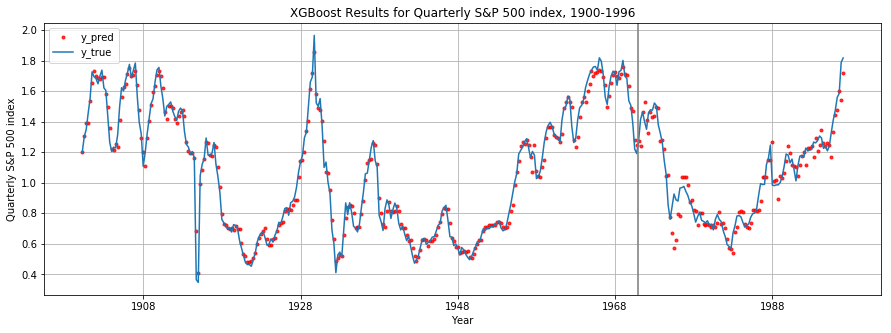

In [41]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe))
y_pred.index = df.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(df, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x='1970-12', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Quarterly S&P 500 index, 1900-1996')
plt.xlabel('Year')
plt.ylabel('Quarterly S&P 500 index')

In [42]:
mse_train = mean_squared_error(df.loc[:'1970'], y_pred[:'1970'])
mse_test = mean_squared_error(df.loc['1970':], y_pred['1970':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.00253547256539
MSE test = 0.0075768806171


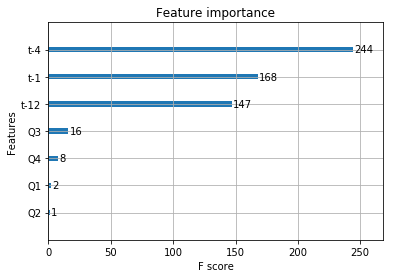

In [43]:
xgb.plot_importance(gbm)

Обобщим резульаты:

| Признаки | Качество на обучении | Качество на контроле
| :- |:-: | :-: | :-:
| $t-2 \text{,  } t-1$, Qs | 0.00359 | 0.00840
| $t-12 \text{,  } t-1 \text{,  } t-4$, Qs | 0.00269 | 0.00753
|  |  |
| Скользящее среднее | 0.03870
| Завтра как вчера  |   0.01122



А как изменится качество, если взять логарифм от данных, и обучить заново?

In [44]:
df_log = np.log(df)
df_log.head()

S&P 500 index
Year                     
1900-03-31       0.181488
1900-06-30       0.262364
1900-09-30       0.298622
1900-12-31       0.375006
1901-03-31       0.439544

Критерий Дики-Фуллера
ADF Statistic: -2.837194
p-value: 0.053154
Critical Values:
	5%: -2.869
	1%: -3.448
	10%: -2.571


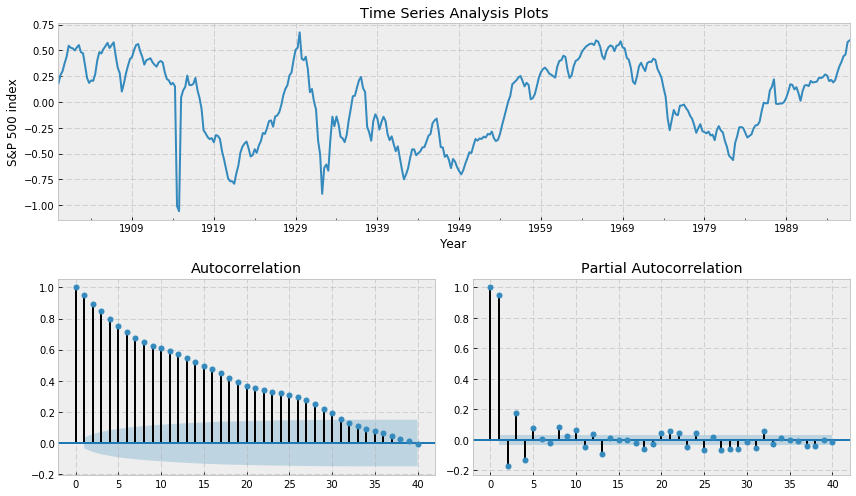

In [45]:
tsplot(df_log['S&P 500 index'], lags=40)

In [46]:
temps = pd.DataFrame(df_log['S&P 500 index'].values)
dataframe_log = pd.concat([temps.shift(12), temps.shift(4), temps.shift(1), qua], axis=1)
dataframe_log.columns = ['t-12', 't-1', 't-4', 'Q1', 'Q2', 'Q3', 'Q4']
dataframe_log.index = df.index
print(dataframe.head(13))

             t-12    t-1    t-4  Q1  Q2  Q3  Q4
Year                                           
1900-03-31    NaN    NaN    NaN   1   0   0   0
1900-06-30    NaN    NaN  1.199   0   1   0   0
1900-09-30    NaN    NaN  1.300   0   0   1   0
1900-12-31    NaN    NaN  1.348   0   0   0   1
1901-03-31    NaN  1.199  1.455   1   0   0   0
1901-06-30    NaN  1.300  1.552   0   1   0   0
1901-09-30    NaN  1.348  1.726   0   0   1   0
1901-12-31    NaN  1.455  1.694   0   0   0   1
1902-03-31    NaN  1.552  1.682   1   0   0   0
1902-06-30    NaN  1.726  1.648   0   1   0   0
1902-09-30    NaN  1.694  1.698   0   0   1   0
1902-12-31    NaN  1.682  1.737   0   0   0   1
1903-03-31  1.199  1.648  1.621   1   0   0   0


In [47]:
gbm = XGBRegressor()
res = gbm.fit(dataframe_log[:'1970'], df_log['S&P 500 index'].loc[:'1970'])

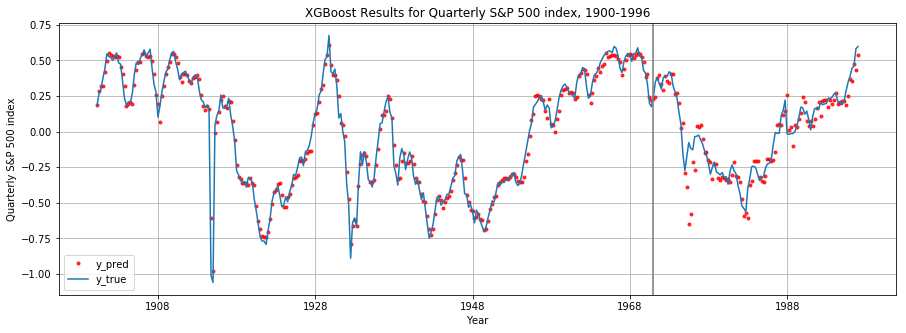

In [48]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe_log))
y_pred.index = df.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(df_log['S&P 500 index'], label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x='1970-12', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Quarterly S&P 500 index, 1900-1996')
plt.xlabel('Year')
plt.ylabel('Quarterly S&P 500 index')

In [49]:
mse_train = mean_squared_error(df_log.loc[:'1970'], y_pred[:'1970'])
mse_test = mean_squared_error(df_log.loc['1970':], y_pred['1970':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.00264196544484
MSE test = 0.0106459988288


In [50]:
y_pred = np.exp(y_pred)
y_pred.head()

0
Year                
1900-03-31  1.203677
1900-06-30  1.326711
1900-09-30  1.381542
1900-12-31  1.381298
1901-03-31  1.521089

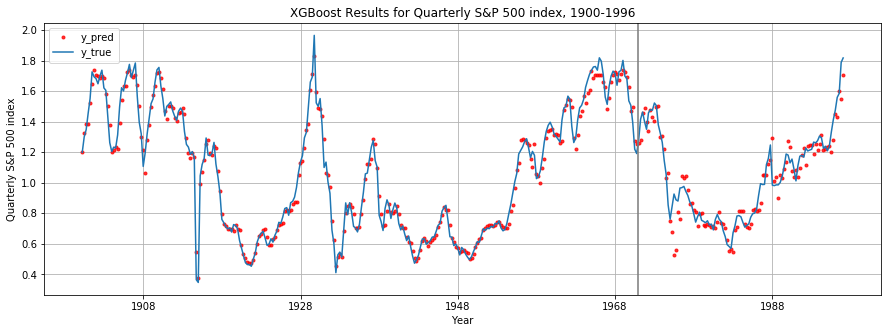

In [51]:
plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(df['S&P 500 index'], label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x='1970-12', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Quarterly S&P 500 index, 1900-1996')
plt.xlabel('Year')
plt.ylabel('Quarterly S&P 500 index')

In [52]:
mse_train = mean_squared_error(df.loc[:'1970'], y_pred[:'1970'])
mse_test = mean_squared_error(df.loc['1970':], y_pred['1970':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.00260294351903
MSE test = 0.00861226283828


Стало чуть лучше на обучении, но на контроле результат ухудшился!

### Monthly CPI, Canada, 1950-1973

In [53]:
df = pd.read_csv('Project TS/monthly-cpi-canada-19501973.csv', parse_dates=True, dayfirst=True)
df.head()

Month,"Monthly CPI, Canada, 1950-1973"
1950-01-01                                    77.5
1950-02-01                                    77.6
1950-03-01                                    78.1
1950-04-01                                    78.3
1950-05-01                                    78.3

In [54]:
df['Month'] = df.index.map(lambda x: x.month)

df.columns = ['Monthly CPI', 'Month']
df['Monthly CPI'] = df['Monthly CPI'].astype(float)

In [55]:
df = pd.concat([df, pd.get_dummies(df['Month'])], axis=1)
df.head()

Monthly CPI  Month  1  2  3  4  5  6  7  8  9  10  11  12
1950-01-01         77.5      1  1  0  0  0  0  0  0  0  0   0   0   0
1950-02-01         77.6      2  0  1  0  0  0  0  0  0  0   0   0   0
1950-03-01         78.1      3  0  0  1  0  0  0  0  0  0   0   0   0
1950-04-01         78.3      4  0  0  0  1  0  0  0  0  0   0   0   0
1950-05-01         78.3      5  0  0  0  0  1  0  0  0  0   0   0   0

In [56]:
avg = df.groupby(by=df['Month'])['Monthly CPI'].mean()
df['MonthAvg'] = df.Month.map(lambda x: avg[df['Month'][x-1]])

In [57]:
df.head()

Monthly CPI  Month  1  2  3  4  5  6  7  8  9  10  11  12  \
1950-01-01         77.5      1  1  0  0  0  0  0  0  0  0   0   0   0   
1950-02-01         77.6      2  0  1  0  0  0  0  0  0  0   0   0   0   
1950-03-01         78.1      3  0  0  1  0  0  0  0  0  0   0   0   0   
1950-04-01         78.3      4  0  0  0  1  0  0  0  0  0   0   0   0   
1950-05-01         78.3      5  0  0  0  0  1  0  0  0  0   0   0   0   

              MonthAvg  
1950-01-01  104.675000  
1950-02-01  104.825000  
1950-03-01  104.962500  
1950-04-01  105.441667  
1950-05-01  105.512500

In [58]:
df.drop(labels='Month', axis=1, inplace=True)

Критерий Дики-Фуллера
ADF Statistic: 3.840195
p-value: 1.000000
Critical Values:
	5%: -2.872
	1%: -3.455
	10%: -2.572


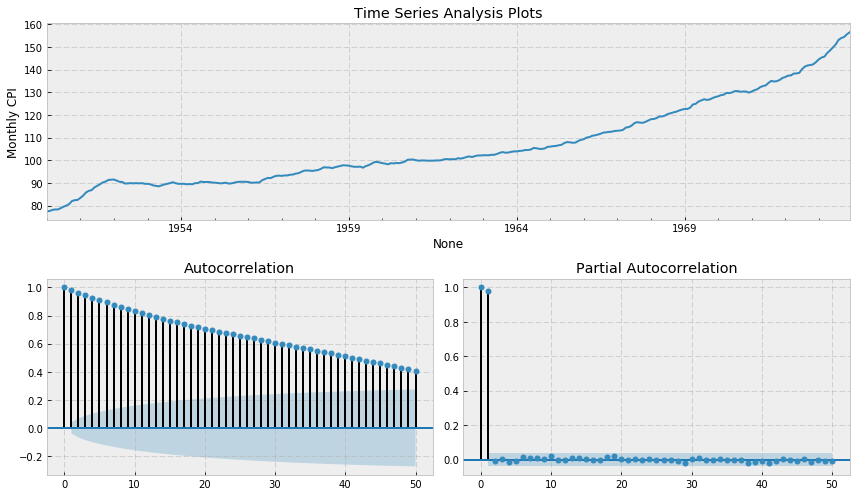

In [59]:
tsplot(df['Monthly CPI'], lags=50)

MSE =  5.90585879828


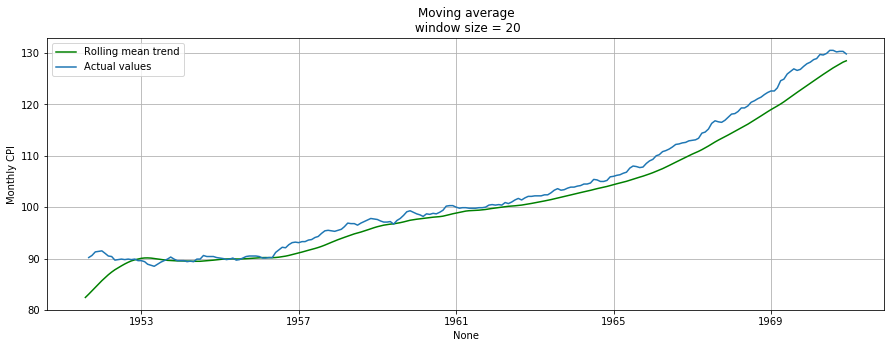

In [60]:
plotMovingAverage(df['Monthly CPI'][:'1970'], 20)

MSE =  0.170717131474


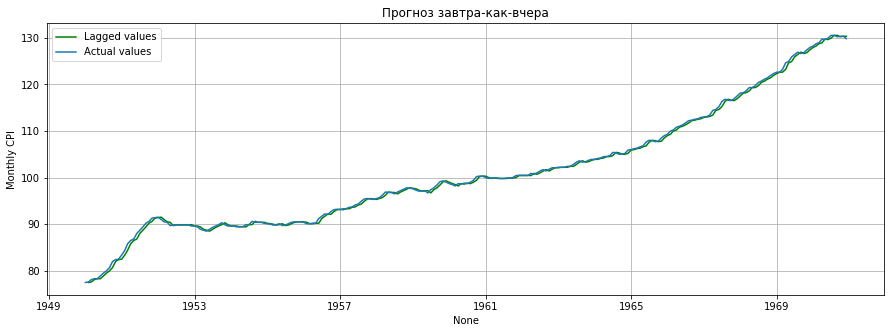

In [61]:
plotLag(df['Monthly CPI'][:'1970'])

По графикам видно, что ряд – это сплошной восходящий тренд. Интересно, как в таком случае справится xgboost, если добавить только самые базовые признаки, какие можно извлечь из данных, а именно, средние значения по месяцам и закодированные месяцы.

In [62]:
months_lst = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
dataframe = df[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'MonthAvg']]
dataframe.head()

1  2  3  4  5  6  7  8  9  10  11  12    MonthAvg
1950-01-01  1  0  0  0  0  0  0  0  0   0   0   0  104.675000
1950-02-01  0  1  0  0  0  0  0  0  0   0   0   0  104.825000
1950-03-01  0  0  1  0  0  0  0  0  0   0   0   0  104.962500
1950-04-01  0  0  0  1  0  0  0  0  0   0   0   0  105.441667
1950-05-01  0  0  0  0  1  0  0  0  0   0   0   0  105.512500

In [63]:
df.drop(labels=[1, 2, 3, 4, 5 ,6, 7, 8 ,9, 10, 11, 12, 'MonthAvg'], axis=1, inplace=True)

In [64]:
gbm = XGBRegressor()
res = gbm.fit(dataframe[:'1970'], df['Monthly CPI'].loc[:'1970'])

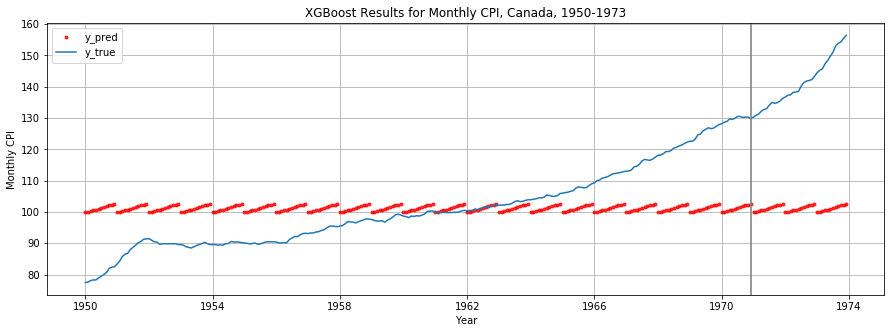

In [65]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe))
y_pred.index = df.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(df['Monthly CPI'], label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x='1970-12', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Monthly CPI, Canada, 1950-1973')
plt.xlabel('Year')
plt.ylabel('Monthly CPI')

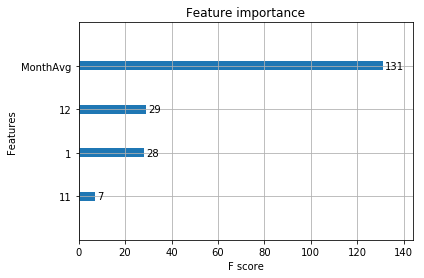

In [66]:
xgb.plot_importance(gbm)

In [67]:
mse_train = mean_squared_error(df.loc[:'1970'], y_pred[:'1970'])
mse_test = mean_squared_error(df.loc['1970':], y_pred['1970':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  164.61648797
MSE test = 1443.91186084


Получили совсем плохую модель, но это тоже важное знание!

Теперь добавим лаги (сразу лучшие, поскольку действия ничем не отличаются от предыдущих):

In [68]:
temps = pd.DataFrame(df.values)
mnth = pd.DataFrame(dataframe.values)
dataframe_1 = pd.concat([temps.shift(12), temps.shift(1), mnth], axis=1)
dataframe_1.columns = ['t-12', 't-1', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', 'MonthAvg']
dataframe_1.index = df.index
print(dataframe_1.head(10))

            t-12   t-1   01   02   03   04   05   06   07   08   09   10   11  \
1950-01-01   NaN   NaN  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1950-02-01   NaN  77.5  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1950-03-01   NaN  77.6  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1950-04-01   NaN  78.1  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1950-05-01   NaN  78.3  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1950-06-01   NaN  78.3  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1950-07-01   NaN  78.9  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1950-08-01   NaN  79.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
1950-09-01   NaN  80.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
1950-10-01   NaN  80.7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   

             12    MonthAvg  
1950-01-01  0.0  104.675000  
1950-02-01  0.0  104.825000  
1950-03-01  0.0  1

In [69]:
gbm = XGBRegressor()
res = gbm.fit(dataframe_1[:'1970'], df.loc[:'1970'])

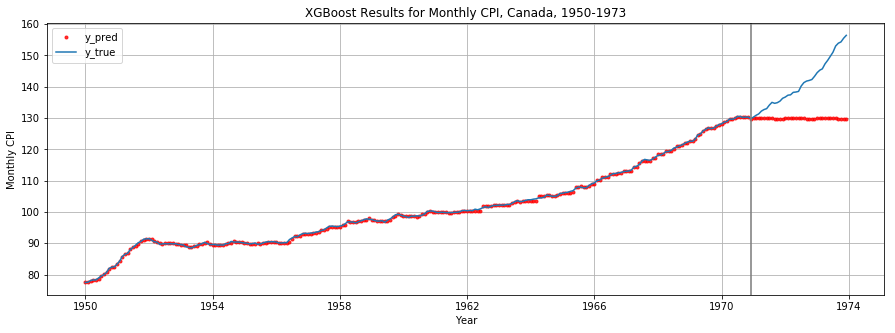

In [70]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe_1))
y_pred.index = df.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(df, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x='1970-12', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Monthly CPI, Canada, 1950-1973')
plt.xlabel('Year')
plt.ylabel('Monthly CPI')

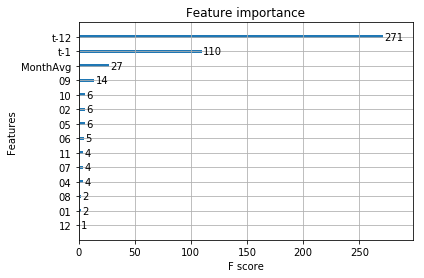

In [71]:
xgb.plot_importance(gbm)

In [72]:
mse_train = mean_squared_error(df.loc[:'1970'], y_pred[:'1970'])
mse_test = mean_squared_error(df.loc['1970':], y_pred['1970':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.0488735421768
MSE test = 139.460475315


Алгоритм все равно не уловил тренд на конроле, поэтому его надо убрать! Вычтем из каждого значения предыдщуее:

In [73]:
df_t_1 = temps.shift(1)
df_t_1.index = df.index

differenced = pd.DataFrame(data=(df['Monthly CPI'] - df_t_1[0]), index=df.index )
differenced.columns= ['Monthly CPI']
differenced.head()

Monthly CPI
1950-01-01          NaN
1950-02-01          0.1
1950-03-01          0.5
1950-04-01          0.2
1950-05-01          0.0

In [74]:
differenced.dropna(inplace=True)

Критерий Дики-Фуллера
ADF Statistic: -1.649128
p-value: 0.457495
Critical Values:
	5%: -2.872
	1%: -3.455
	10%: -2.572


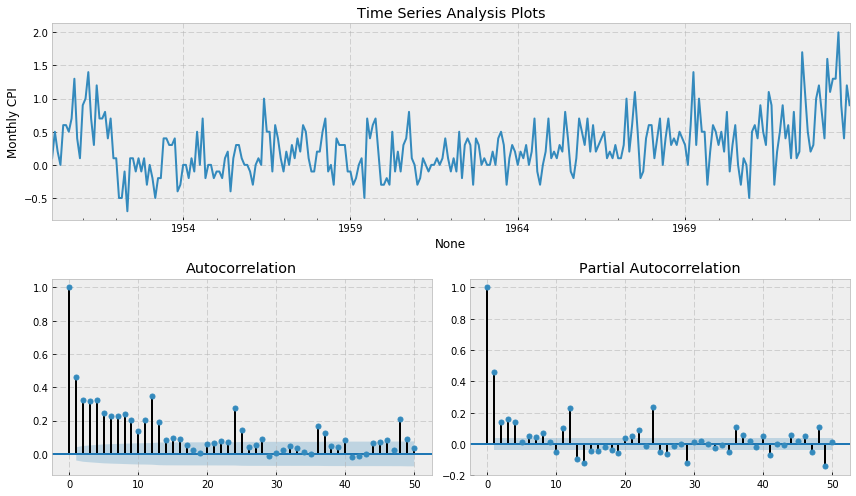

In [75]:
tsplot(differenced['Monthly CPI'], lags=50)

In [76]:
differenced['Month'] = differenced.index.map(lambda x: x.month)
avg_dif = differenced.groupby(by=differenced['Month'])['Monthly CPI'].mean()
differenced['MonthAvg'] = differenced.Month.map(lambda x: avg_dif[differenced['Month'][x-1]])

In [77]:
differenced.groupby(by=differenced['Month'])['Monthly CPI'].mean()

Month
1     0.173913
2     0.150000
3     0.137500
4     0.479167
5     0.070833
6     0.400000
7     0.512500
8     0.454167
9     0.141667
10    0.283333
11    0.300000
12    0.191667
Name: Monthly CPI, dtype: float64

In [78]:
differenced.head()

Monthly CPI  Month  MonthAvg
1950-02-01          0.1      2  0.137500
1950-03-01          0.5      3  0.479167
1950-04-01          0.2      4  0.070833
1950-05-01          0.0      5  0.400000
1950-06-01          0.6      6  0.512500

In [79]:
dataframe_dif = dataframe
dataframe_dif.drop(labels='MonthAvg', axis=1, inplace=True)
dataframe_dif['MthAvg'] = differenced['MonthAvg']
differenced.drop(labels=['Month', 'MonthAvg'], axis=1, inplace=True)

/Users/ola/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/ola/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [80]:
temps = pd.DataFrame(differenced.values)
mnth = pd.DataFrame(dataframe_dif.values)
dataframe_diff = pd.concat([temps.shift(3), temps.shift(2), temps.shift(1), mnth], axis=1)
dataframe_diff.columns = ['t-3', 't-2', 't-1', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', 'MonthAvg']
dataframe_diff.index = df.index

In [81]:
dataframe_dif.dropna(inplace=True)

/Users/ola/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [82]:
dataframe_diff.index = df.index

In [83]:
dataframe_diff

t-3  t-2  t-1   01   02   03   04   05   06   07   08   09   10  \
1950-01-01  NaN  NaN  NaN  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1950-02-01  NaN  NaN  0.1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1950-03-01  NaN  0.1  0.5  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1950-04-01  0.1  0.5  0.2  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1950-05-01  0.5  0.2  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1950-06-01  0.2  0.0  0.6  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1950-07-01  0.0  0.6  0.6  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
1950-08-01  0.6  0.6  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
1950-09-01  0.6  0.5  0.7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
1950-10-01  0.5  0.7  1.3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
1950-11-01  0.7  1.3  0.4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1950-12-01  1.3  0.4  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1951-01-01  0.4  0.1  0.9  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1951-02-01  0.1  0.9  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1951-03-01  0.9  1.0  1.4  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1951-04-01  1.0  1.4  0.7  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1951-05-01  1.4  0.7  0.3  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1951-06-01  0.7  0.3  1.2  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1951-07-01  0.3  1.2  0.7  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
1951-08-01  1.2  0.7  0.7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
1951-09-01  0.7  0.7  0.8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
1951-10-01  0.7  0.8  0.4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
1951-11-01  0.8  0.4  0.7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1951-12-01  0.4  0.7  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1952-01-01  0.7  0.1  0.1  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1952-02-01  0.1  0.1 -0.5  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1952-03-01  0.1 -0.5 -0.5  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1952-04-01 -0.5 -0.5 -0.1  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1952-05-01 -0.5 -0.1 -0.7  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1952-06-01 -0.1 -0.7  0.1  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1971-07-01  0.5  0.3  1.1  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
1971-08-01  0.3  1.1  0.9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
1971-09-01  1.1  0.9 -0.3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
1971-10-01  0.9 -0.3  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
1971-11-01 -0.3  0.2  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1971-12-01  0.2  0.5  0.9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1972-01-01  0.5  0.9  0.4  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1972-02-01  0.9  0.4  0.6  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1972-03-01  0.4  0.6  0.1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1972-04-01  0.6  0.1  0.8  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1972-05-01  0.1  0.8  0.1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1972-06-01  0.8  0.1  0.2  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1972-07-01  0.1  0.2  1.7  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
1972-08-01  0.2  1.7  1.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
1972-09-01  1.7  1.1  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
1972-10-01  1.1  0.5  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
1972-11-01  0.5  0.2  0.3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1972-12-01  0.2  0.3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1973-01-01  0.3  1.0  1.2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [84]:
gbm = XGBRegressor()
res = gbm.fit(dataframe_diff['1950-02-01':'1970'], differenced.loc[:'1970'])

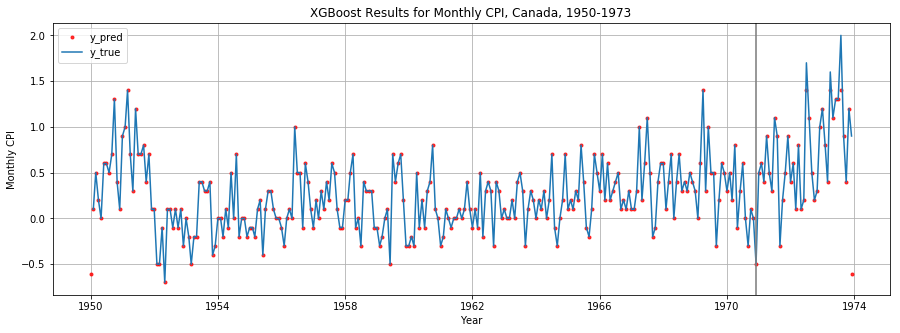

In [85]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe_diff))
y_pred.index = df.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(differenced, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x='1970-12', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Monthly CPI, Canada, 1950-1973')
plt.xlabel('Year')
plt.ylabel('Monthly CPI')

In [86]:
mse_train = mean_squared_error(differenced.loc['1950-02-01':'1970'], y_pred['1950-02-01':'1970-12-01'])
mse_test = mean_squared_error(differenced.loc['1970':], y_pred['1970':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  1.77550041494e-07
MSE test = 0.0577648637066


In [87]:
y_pred[1] = [0] * y_pred.shape[0]
y_pred[1]['1950-01-01'] = df['Monthly CPI']['1950-01-01']
y_pred.head()

/Users/ola/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


0   1
1950-01-01 -0.610005  77
1950-02-01  0.100014   0
1950-03-01  0.499939   0
1950-04-01  0.199995   0
1950-05-01  0.000054   0

In [88]:
# восстановим истинные значени

for i in range(y_pred.shape[0]-1):
    y_pred[1].iloc[i+1] = y_pred[1].iloc[i] + y_pred[0].iloc[i+1]
y_pred.head()

/Users/ola/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0          1
1950-01-01 -0.610005  77.000000
1950-02-01  0.100014  77.100014
1950-03-01  0.499939  77.599953
1950-04-01  0.199995  77.799948
1950-05-01  0.000054  77.800003

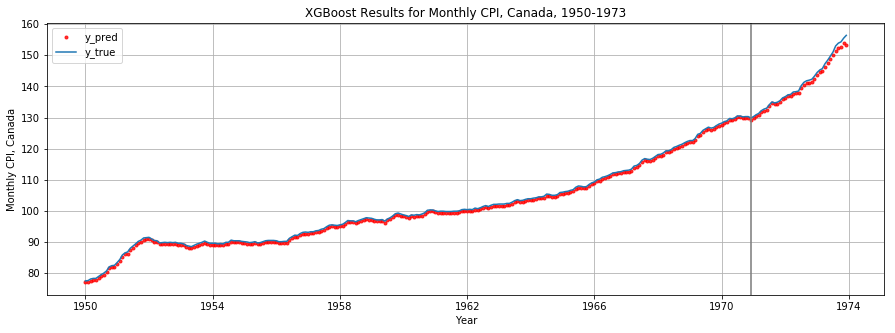

In [89]:
#y_pred = pd.DataFrame(data=gbm.predict(dataframe))
#y_pred.index = df.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred[1], "r.", alpha=0.8, label="y_pred")
plt.plot(df['Monthly CPI'], label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающуей и тестовой выборок
plt.axvline(x='1970-12', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Monthly CPI, Canada, 1950-1973')
plt.xlabel('Year')
plt.ylabel('Monthly CPI, Canada')

In [90]:
mse_train = mean_squared_error(df['Monthly CPI'].loc[:'1970'], y_pred[1][:'1970'])
mse_test = mean_squared_error(df['Monthly CPI'].loc['1970':], y_pred[1]['1970':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.243317369285
MSE test = 0.769526460868


В итоге получилось:

| Признаки | Качество на обучении | Качество на контроле
| :- |:-: | :-: | :-:
| Самые базовые | 164 | 1444
| С лагами | 0.04887 | 139
| Без тренда | 0.24 | 0.77 
|  |  |
| Скользящее среднее | 5.9
| Завтра как вчера  |  0.17

### Monthly champagne sales (in 1000's) (p.273: Montgomery: Fore. & T.S.)

In [91]:
df = pd.read_csv('Project TS/monthly-champagne-sales-in-1000s.csv')
df.tail()

Month  \
92                                               8-09   
93                                               8-10   
94                                               8-11   
95                                               8-12   
96  Monthly champagne sales (in 1000's) (p.273: Mo...   

    Monthly champagne sales (in 1000's) (p.273: Montgomery: Fore. & T.S.)  
92                                             5951.0                      
93                                             6981.0                      
94                                             9851.0                      
95                                            12670.0                      
96                                                NaN

In [92]:
df.drop(df.index[-1], inplace=True)

df.columns=['Month', 'Champagne sales']

df['Year'] = df['Month'].map(lambda x: x[0])
df['Month'] = df['Month'].map(lambda x: x[-2:])

df.index = pd.date_range(start='01-2001', end='01-2009', freq='M')

df_features = df['Month']
df.drop(labels=['Month', 'Year'], axis=1, inplace=True)

In [93]:
df_features = pd.get_dummies(df_features, drop_first=False)

Критерий Дики-Фуллера
ADF Statistic: -1.639192
p-value: 0.462683
Critical Values:
	5%: -2.897
	1%: -3.511
	10%: -2.585


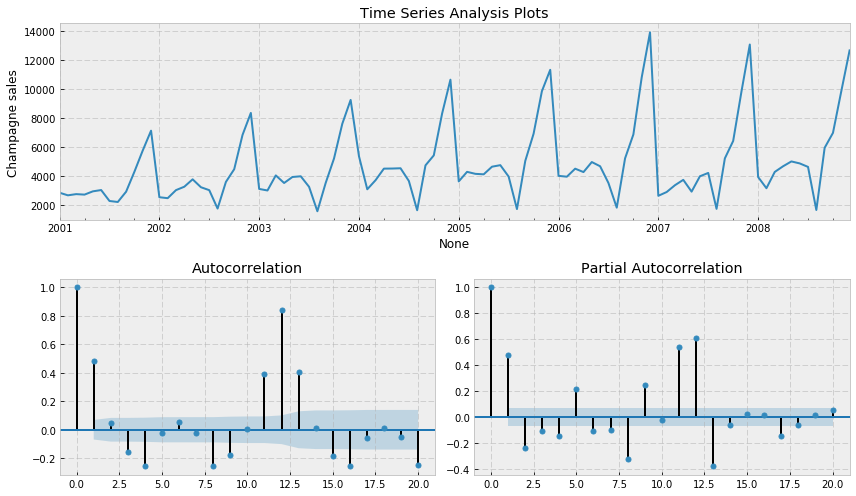

In [94]:
tsplot(df['Champagne sales'], lags=20)

MSE =  4588954.6713


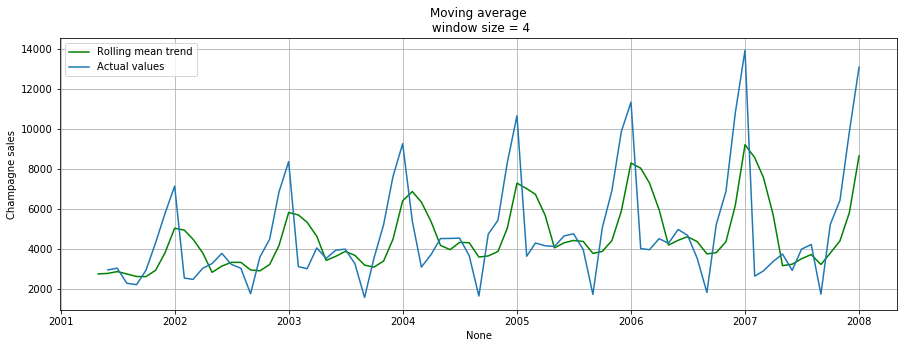

In [95]:
plotMovingAverage(df['Champagne sales'][:'2007'], 4)

MSE =  5912249.79518


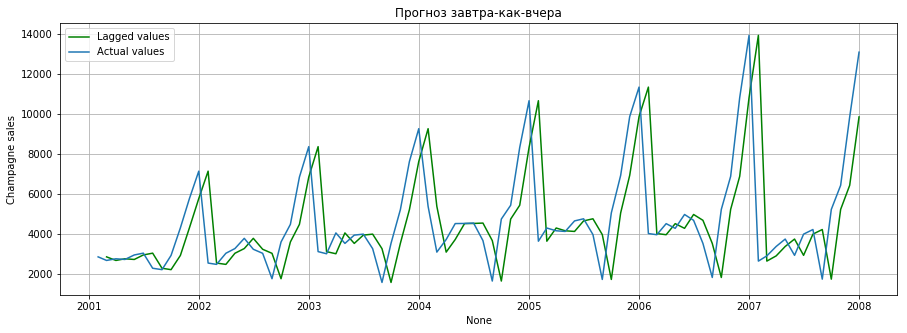

In [96]:
plotLag(df['Champagne sales'][:'2007'])

Посмотрим поближе, чтобы выяснить, когда случаютс пики:

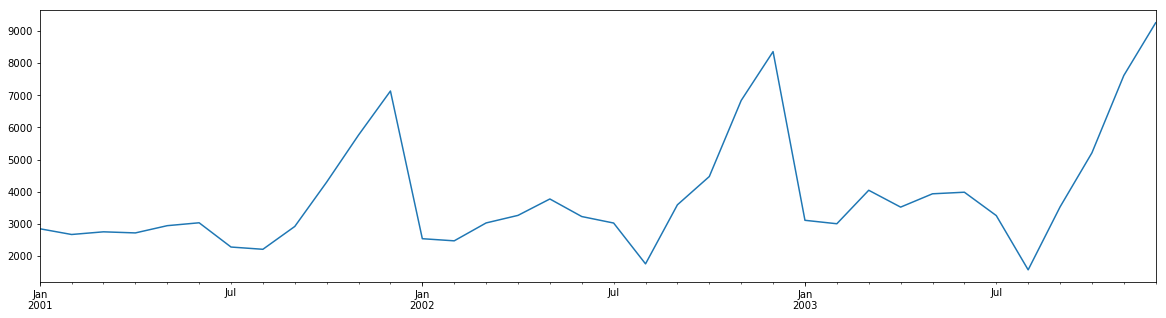

In [97]:
df['Champagne sales'][:'2003'].plot(figsize=(20,5))

Пики случаются каждый декабрь, а падения – каждый август, значит, стоит ожидать, что эти переменные будут очень значимыми!

In [98]:
gbm = XGBRegressor()
res = gbm.fit(df_features.loc[:'2007'], df['Champagne sales'][:'2007'])

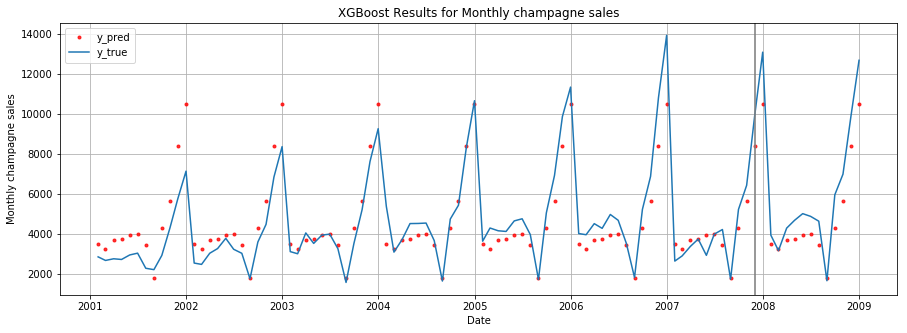

In [99]:
y_pred = pd.DataFrame(data=gbm.predict(df_features))
y_pred.index = df.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(df['Champagne sales'], label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x='2007-12', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Monthly champagne sales')
plt.xlabel('Date')
plt.ylabel('Monthly champagne sales')

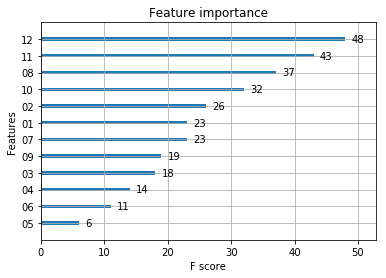

In [100]:
xgb.plot_importance(gbm)

In [101]:
mse_train = mean_squared_error(df['Champagne sales'].loc[:'2007'], y_pred[:'2007'])
mse_test = mean_squared_error(df['Champagne sales'].loc['2007':], y_pred['2007':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  1096935.54697
MSE test = 1201570.10934


Добавим лаги:

In [102]:
temps = pd.DataFrame(df.values)
mnth = pd.DataFrame(df_features.values)
dataframe = pd.concat([temps.shift(12), temps.shift(1), mnth], axis=1)
dataframe.columns = ['t-12', 't-1', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
dataframe.index = df.index

In [103]:
gbm = XGBRegressor()
res = gbm.fit(dataframe.loc[:'2007'], df['Champagne sales'][:'2007'])

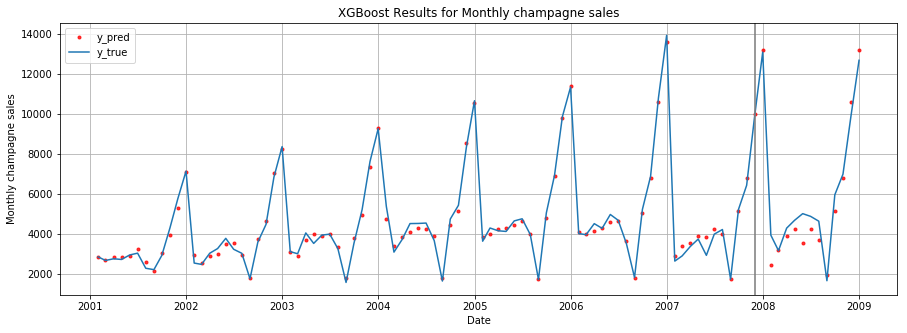

In [104]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe))
y_pred.index = df.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(df['Champagne sales'], label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x='2007-12', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Monthly champagne sales')
plt.xlabel('Date')
plt.ylabel('Monthly champagne sales')

In [105]:
mse_train = mean_squared_error(df['Champagne sales'].loc[:'2007'], y_pred[:'2007'])
mse_test = mean_squared_error(df['Champagne sales'].loc['2007':], y_pred['2007':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  61371.1382546
MSE test = 373913.079873


Обобщим резульаты:

| Признаки | Качество на обучении | Качество на контроле
| :- |:-: | :-: | :-:
| Без лагов |  1096935 | 1201570
| С лагами | 61371 | 373913
|  |  |
| Скользящее среднее | 4588954
| Завтра как вчера  |   5912249

### Daily foreign exchange rates, 31 December 1979 – 31 December 1998, Swiss-US

In [107]:
df = pd.read_csv('Project TS/daily-foreign-exchange-rates-31-.csv', index_col=['Date'], parse_dates=['Date'])
df = df[0:4774]
df.tail()

Daily foreign exchange rates, 31 December 1979 ? 31 December 1998
Date                                                                        
1998-12-24                                              1.376               
1998-12-28                                              1.372               
1998-12-29                                              1.363               
1998-12-30                                              1.381               
1998-12-31                                              1.374

In [108]:
df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'] = df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'].astype(float)

In [109]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh', name=None):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        ts_ax.set_xlabel(df.index.name)
        ts_ax.set_ylabel(name)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера")
        result = sm.tsa.stattools.adfuller(y)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
                


        plt.tight_layout()
    return 

Критерий Дики-Фуллера
ADF Statistic: -1.356378
p-value: 0.603001
Critical Values:
	5%: -2.862
	1%: -3.432
	10%: -2.567


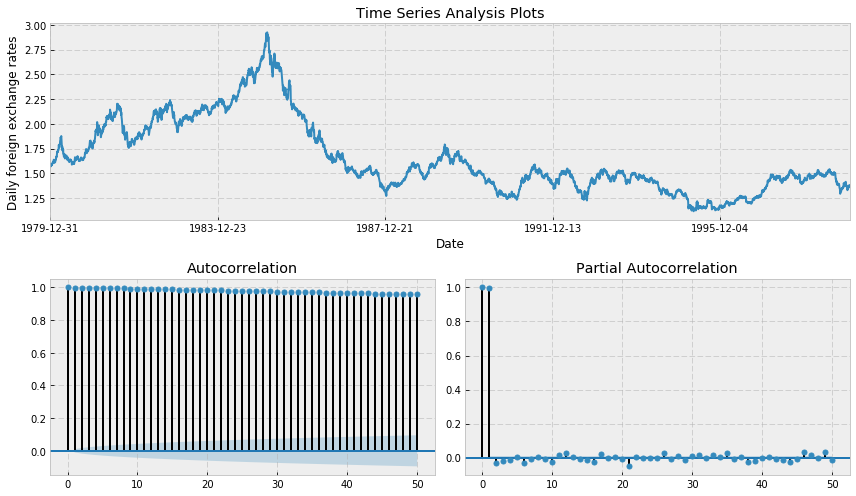

In [110]:
tsplot(df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'], lags=50, name='Daily foreign exchange rates')

Построим наивный прогноз, предполагая, что будущее знчение переменной завиист от $n$ её предыдущих значений, следующим образом:

$$\hat{y_t} = \frac{1}{k} \sum_{n=0}^{k-1} y_{t-n},$$

и посчитаем для него среднеквадратичную ошибку.

In [114]:
def moving_average(data, n):
    return np.average(data[-n:])

def plotMovingAverage(data, n, name=None):

    rolling_mean = data.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    y = pd.Series(rolling_mean)
    y.plot(label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    
    y2 = pd.Series(data[n:])
    y2.plot(label="Actual values", color="green")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xlabel(df.index.name)
    plt.ylabel(name)

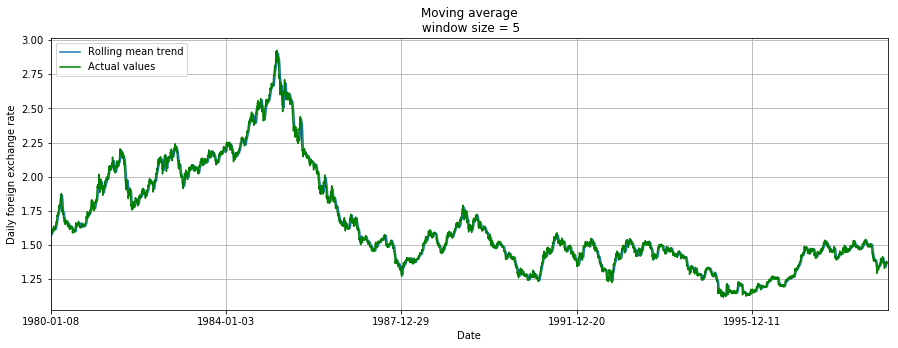

In [115]:
plotMovingAverage(df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'], n=5, name='Daily foreign exchange rate')

Посмотрим в увеличенном масштабе первые 500 объектов.

In [116]:
plotMovingAverage(df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'][0:500], n=5)

In [118]:
print('MSE =' , mean_squared_error(df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'][(5-1):3580], df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'].rolling(window=5).mean()[(5-1):3580]))

MSE = 0.000258867527964


Построим ещё один прогноз, предполагая, что значенияе завтра будет таким же, как вчера, и посчитаем для него срднеквадратичную ошибку.

In [119]:
def plotLag(data, name=None):
    
    lag_data = pd.Series(data.shift(periods=1))
    
    plt.figure(figsize=(15,5))
    plt.title('Tomorrow as yesterday predictions')
    lag_data.plot(label="Lagged values")
    
    y3 = pd.Series(data)
    y3.plot(label="Actual values", color="green")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xlabel(df.index.name)
    plt.ylabel(name)
    
    return

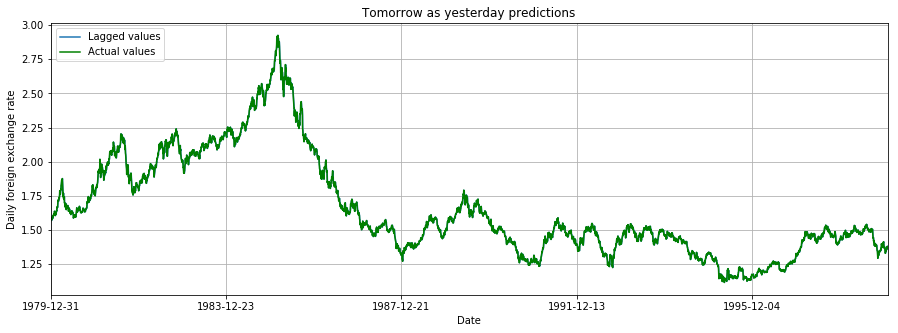

In [120]:
plotLag(df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'], name='Daily foreign exchange rate')

Посмотрим в увеличенном масштабе первые 100 объектов.

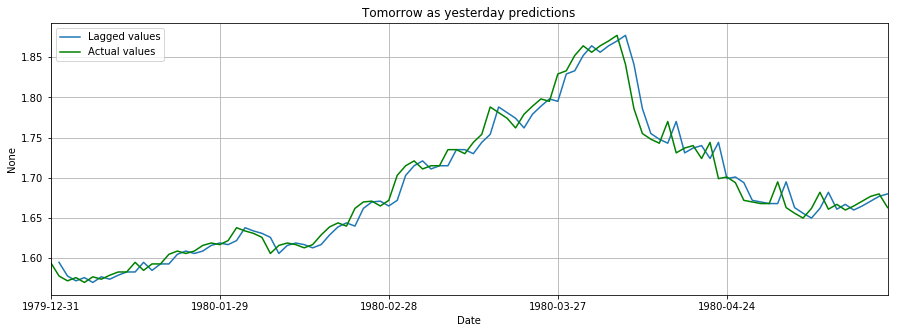

In [121]:
plotLag(df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'][0:100])

In [123]:
print('MSE =', mean_squared_error(df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'][1:3580], pd.Series(df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'].shift(periods=1))[1:3580]))

MSE = 0.000201024867281


Получили, что в обоих случаях среднеквадратичные ошибки примерно одинаковы и равны $\sim 0.0002$, однако этот результат сильно зависит от ширины окна в прогнозе скользящего среднего.
Теперь нужно добавить признаки.

In [124]:
y = pd.DataFrame(df.values)
df_features = pd.DataFrame()

for i in range(7,-1,-1):
    df_features['t-'+str(i)] = df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'].shift(i)
    
dataframe = df_features[7:]
dataframe['Month'] = dataframe.index.map(lambda x: int(x.split('-')[1]))
dataframe['Month by order'] = dataframe.index.map(lambda x: int(x.split('-')[0])-1980+int(x.split('-')[1]))
avg_dif = dict(dataframe.groupby(by=dataframe['Month by order'])['t-0'].mean())
dataframe['MonthAvg'] = dataframe['Month by order'].map(lambda x: avg_dif[x])
def quarter(x):
    if x<4:
        return(1)
    elif x<7:
        return(2)
    elif x<10:
        return(3)
    else:
        return(4)
dataframe['Quarter'] = dataframe['Month'].map(lambda x: quarter(x))
dataframe = pd.get_dummies(dataframe, columns=['Month'])

/Users/ola/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ola/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ola/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

In [125]:
dataframe.head(2)

t-7    t-6    t-5    t-4    t-3    t-2    t-1    t-0  \
Date                                                                 
1980-01-10  1.595  1.578  1.572  1.576  1.570  1.577  1.574  1.579   
1980-01-11  1.578  1.572  1.576  1.570  1.577  1.574  1.579  1.583   

            Month by order  MonthAvg    ...     Month_3  Month_4  Month_5  \
Date                                    ...                                 
1980-01-10               1   1.60325    ...           0        0        0   
1980-01-11               1   1.60325    ...           0        0        0   

            Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  Month_12  
Date                                                                          
1980-01-10        0        0        0        0         0         0         0  
1980-01-11        0        0        0        0         0         0         0  

[2 rows x 23 columns]

In [126]:
gbm = xgb.XGBRegressor()

In [127]:
res = gbm.fit(dataframe.drop('t-0', axis=1)[0:3580], y[0:3580])

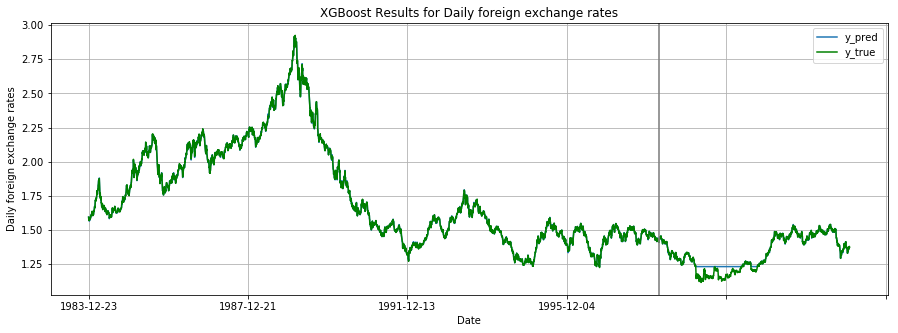

In [129]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe.drop('t-0', axis=1)))
y_pred.index = dataframe.index
style='bmh'

plt.figure(figsize=(15, 5))
plt.title('XGBoost Results for Daily foreign exchange rates')

pd.Series(y_pred[0]).plot(label='y_pred')
df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'].plot(label="y_true", color='green')

plt.axis('tight')
plt.grid(True)
    # линия обозначает границу обучающей и тестовой выборок
plt.axvline(x=3580, color='grey',  linewidth=2, alpha=0.8)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Daily foreign exchange rates')

Увеличим масштаб.

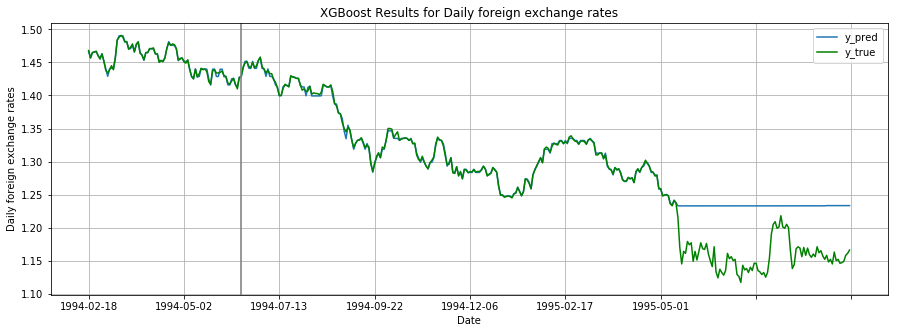

In [130]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe.drop('t-0', axis=1)))
y_pred.index = dataframe.index
style='bmh'


plt.figure(figsize=(15, 5))
plt.title('XGBoost Results for Daily foreign exchange rates')

pd.Series(y_pred[0])[3500:3900].plot(label="y_pred")
df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'][3500:3900].plot(label="y_true", color='green')

plt.axis('tight')
plt.grid(True)
    # линия обозначает границу обучающей и тестовой выборок
plt.axvline(x=80, color='grey',  linewidth=2, alpha=0.8)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Daily foreign exchange rates')

Необычное поведение графика предсказний после 1995.02.17 объясняется тем, что в предыдыдущие периоды меньших значений, чем 1.25 не было, поэтому алгоритм не может предсказать что-то иное по обучающей выборке. 

In [131]:
mse_train = mean_squared_error(df.iloc[30:3580], y_pred[0:3550])
mse_test = mean_squared_error(df.iloc[3580:4774], y_pred[3550:4744])

print('MSE train =' , mse_train)
print('MSE test =', mse_test)

MSE train = 0.00776415689111
MSE test = 0.0031993373305


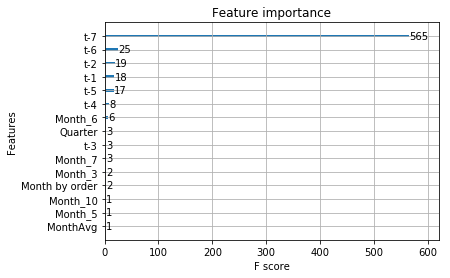

In [132]:
xgb.plot_importance(gbm)

И тут начинается магия. Я заметила, что если три раза повторить следующий cell, то предсказание получается гораздо лучше. Так что мы будем предсказывать не разность "сегодня" и "вчера", а сумму разностей "сегодня" и "вчера" и "позавчера" и "позапозавчера". Для убедительности сначала сделаем прогноз на обычную разность, а потом на магическую.

In [133]:
df_t_1 = y.shift(1)
df_t_1.index = df.index

diff = pd.DataFrame(data=(df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'] - df_t_1[0]), index=df.index )
diff.columns = ['Difference in rate']
diff.head(5)

Difference in rate
Date                          
1979-12-31                 NaN
1980-01-02              -0.017
1980-01-03              -0.006
1980-01-04               0.004
1980-01-07              -0.006

In [134]:
y = pd.DataFrame(diff.values)
df_features = pd.DataFrame()

for i in range(7,-1,-1):
    df_features['t-'+str(i)] = diff['Difference in rate'].shift(i)
    
dataframe = df_features[8:]
dataframe.head(5)

t-7    t-6    t-5    t-4    t-3    t-2    t-1    t-0
Date                                                              
1980-01-11 -0.017 -0.006  0.004 -0.006  0.007 -0.003  0.005  0.004
1980-01-14 -0.006  0.004 -0.006  0.007 -0.003  0.005  0.004  0.000
1980-01-15  0.004 -0.006  0.007 -0.003  0.005  0.004  0.000  0.012
1980-01-16 -0.006  0.007 -0.003  0.005  0.004  0.000  0.012 -0.010
1980-01-17  0.007 -0.003  0.005  0.004  0.000  0.012 -0.010  0.008

In [135]:
dataframe['Month'] = dataframe.index.map(lambda x: int(x.split('-')[1]))
dataframe['Month by order'] = dataframe.index.map(lambda x: int(x.split('-')[0])-1980+int(x.split('-')[1]))
avg_dif = dict(dataframe.groupby(by=dataframe['Month by order'])['t-0'].mean())
dataframe['MonthAvg'] = dataframe['Month by order'].map(lambda x: avg_dif[x])
def quarter(x):
    if x<4:
        return(1)
    elif x<7:
        return(2)
    elif x<10:
        return(3)
    else:
        return(4)
dataframe['Quarter'] = dataframe['Month'].map(lambda x: quarter(x))
dataframe = pd.get_dummies(dataframe, columns=['Month'])

/Users/ola/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ola/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/ola/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [136]:
dataframe.head(2)

t-7    t-6    t-5    t-4    t-3    t-2    t-1    t-0  \
Date                                                                 
1980-01-11 -0.017 -0.006  0.004 -0.006  0.007 -0.003  0.005  0.004   
1980-01-14 -0.006  0.004 -0.006  0.007 -0.003  0.005  0.004  0.000   

            Month by order  MonthAvg    ...     Month_3  Month_4  Month_5  \
Date                                    ...                                 
1980-01-11               1  0.003933    ...           0        0        0   
1980-01-14               1  0.003933    ...           0        0        0   

            Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  Month_12  
Date                                                                          
1980-01-11        0        0        0        0         0         0         0  
1980-01-14        0        0        0        0         0         0         0  

[2 rows x 23 columns]

In [137]:
gbm2 = xgb.XGBRegressor()

In [138]:
res = gbm2.fit(dataframe[0:3580].drop('t-0', axis=1), dataframe['t-0'][0:3580])

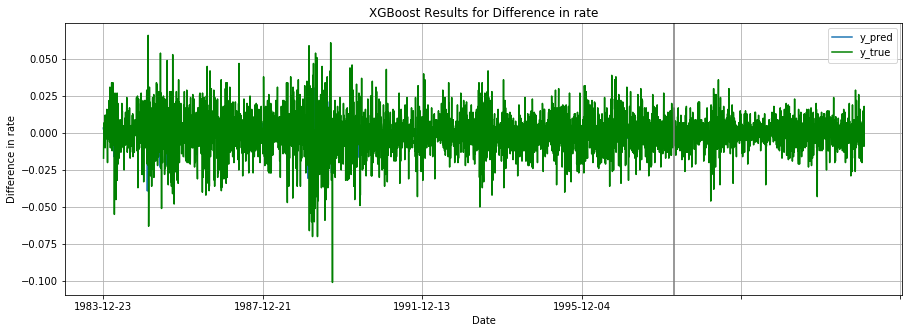

In [140]:
y_pred = pd.DataFrame(data=gbm2.predict(dataframe.drop('t-0', axis=1)))
y_pred.index = dataframe.drop('t-0', axis=1).index
style='bmh'

plt.figure(figsize=(15, 5))
plt.title('XGBoost Results for Difference in rate')

pd.Series(y_pred[0]).plot(label='y_pred')
diff['Difference in rate'].plot(label="y_true", color='green')

plt.axis('tight')
plt.grid(True)
    # линия обозначает границу обучающей и тестовой выборок
plt.axvline(x=3580, color='grey',  linewidth=2, alpha=0.8)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Difference in rate')

In [142]:
y_pred = pd.DataFrame(data=gbm2.predict(dataframe.drop('t-0', axis=1)))
y_pred.index = dataframe.drop('t-0', axis=1).index
style='bmh'

plt.figure(figsize=(15, 5))
plt.title('XGBoost Results for Difference in rate')

pd.Series(y_pred[0])[3500:3800].plot(label='y_pred')
dataframe['t-0'][3500:3800].plot(label="y_true", color='green')

plt.axis('tight')
plt.grid(True)
    # линия обозначает границу обучающей и тестовой выборок
plt.axvline(x=80, color='black',  linewidth=2, alpha=0.8)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Difference in rate')

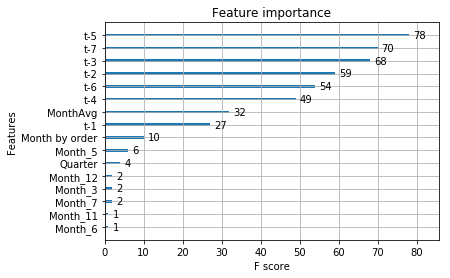

In [143]:
xgb.plot_importance(gbm2)

In [144]:
y_pred[0].iloc[0] = 1.579
for i in range(0,y_pred.shape[0]-1):
    y_pred[0].iloc[i+1] = y_pred[0].iloc[i] + y_pred[0].iloc[i+1]
y_pred.head()

0
Date                
1980-01-11  1.579000
1980-01-14  1.581435
1980-01-15  1.584744
1980-01-16  1.588163
1980-01-17  1.591473

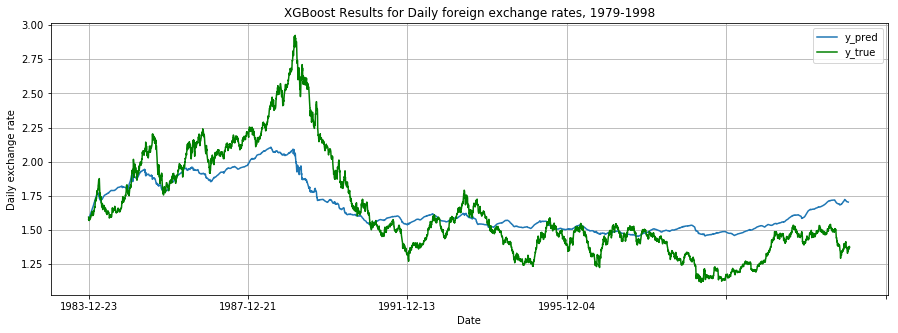

In [146]:
plt.figure(figsize=(15, 5))
y_pred[0].plot(label="y_pred")
df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'].plot(label="y_true", color='green')
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающуей и тестовой выборок
#plt.axvline(x='3580', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Daily foreign exchange rates, 1979-1998')
plt.xlabel('Date')
plt.ylabel('Daily exchange rate')

In [148]:
mse_train = mean_squared_error(df.iloc[30:3580], y_pred[0:3550])
mse_test = mean_squared_error(df.iloc[3580:4774], y_pred[3550:4744])

print('MSE train =' , mse_train)
print('MSE test =', mse_test)

MSE train = 0.0459734905879
MSE test = 0.0552376736464


И второй вариант.

In [149]:
df_t_1 = y.shift(1)
df_t_1.index = df.index

diff = pd.DataFrame(data=(df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'] - df_t_1[0]), index=df.index )
diff.columns = ['Difference in rate']
diff.head(10)
y = pd.DataFrame(diff.values)

df_t_1 = y.shift(1)
df_t_1.index = df.index

diff = pd.DataFrame(data=(df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'] - df_t_1[0]), index=df.index )
diff.columns = ['Difference in rate']
diff.head(5)

Difference in rate
Date                          
1979-12-31                 NaN
1980-01-02                 NaN
1980-01-03                 NaN
1980-01-04              -0.013
1980-01-07              -0.012

In [150]:
y = pd.DataFrame(diff.values)
df_features = pd.DataFrame()

for i in range(7,-1,-1):
    df_features['t-'+str(i)] = diff['Difference in rate'].shift(i)
    
dataframe = df_features[8:]
dataframe.head(5)

t-7    t-6    t-5    t-4    t-3    t-2    t-1    t-0
Date                                                              
1980-01-11    NaN    NaN -0.013 -0.012  0.011 -0.009  0.012  0.001
1980-01-14    NaN -0.013 -0.012  0.011 -0.009  0.012  0.001  0.005
1980-01-15 -0.013 -0.012  0.011 -0.009  0.012  0.001  0.005  0.016
1980-01-16 -0.012  0.011 -0.009  0.012  0.001  0.005  0.016 -0.010
1980-01-17  0.011 -0.009  0.012  0.001  0.005  0.016 -0.010  0.020

In [151]:
dataframe['Month'] = dataframe.index.map(lambda x: int(x.split('-')[1]))
dataframe['Month by order'] = dataframe.index.map(lambda x: int(x.split('-')[0])-1980+int(x.split('-')[1]))
avg_dif = dict(dataframe.groupby(by=dataframe['Month by order'])['t-0'].mean())
dataframe['MonthAvg'] = dataframe['Month by order'].map(lambda x: avg_dif[x])
def quarter(x):
    if x<4:
        return(1)
    elif x<7:
        return(2)
    elif x<10:
        return(3)
    else:
        return(4)
dataframe['Quarter'] = dataframe['Month'].map(lambda x: quarter(x))

/Users/ola/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ola/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/ola/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [152]:
dataframe = pd.get_dummies(dataframe, columns=['Month'])

In [153]:
gbm2 = xgb.XGBRegressor()

In [154]:
res = gbm2.fit(dataframe[0:3580].drop('t-0', axis=1), dataframe['t-0'][0:3580])

In [155]:
y_pred = pd.DataFrame(data=gbm2.predict(dataframe.drop('t-0', axis=1)))
y_pred.index = dataframe.drop('t-0', axis=1).index
style='bmh'

plt.figure(figsize=(15, 5))
plt.title('XGBoost Results for Magic Difference in rate')

pd.Series(y_pred[0]).plot(label='y_pred')
diff['Difference in rate'].plot(label="y_true", color='green')

plt.axis('tight')
plt.grid(True)
    # линия обозначает границу обучающей и тестовой выборок
plt.axvline(x=3580, color='grey',  linewidth=2, alpha=0.8)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Difference in rate')

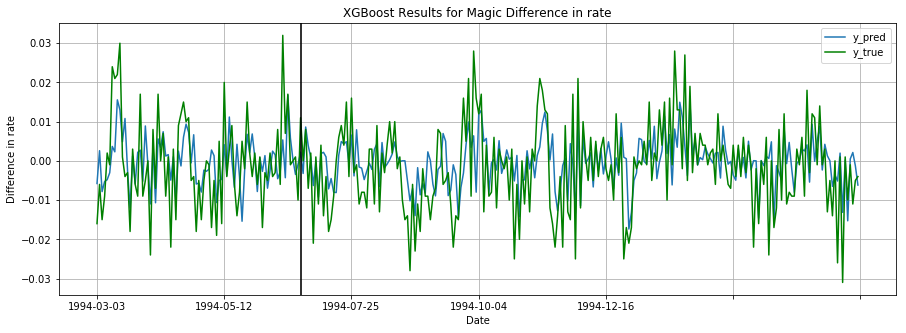

In [156]:
y_pred = pd.DataFrame(data=gbm2.predict(dataframe.drop('t-0', axis=1)))
y_pred.index = dataframe.drop('t-0', axis=1).index
style='bmh'

plt.figure(figsize=(15, 5))
plt.title('XGBoost Results for Magic Difference in rate')

pd.Series(y_pred[0])[3500:3800].plot(label='y_pred')
dataframe['t-0'][3500:3800].plot(label="y_true", color='green')

plt.axis('tight')
plt.grid(True)
    # линия обозначает границу обучающей и тестовой выборок
plt.axvline(x=80, color='black',  linewidth=2, alpha=0.8)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Difference in rate')

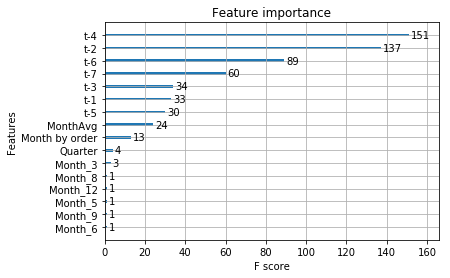

In [157]:
xgb.plot_importance(gbm2)

In [158]:
y_pred[0].iloc[0] = 1.579
for i in range(0,y_pred.shape[0]-1):
    y_pred[0].iloc[i+1] = y_pred[0].iloc[i] + y_pred[0].iloc[i+1]
y_pred.head()

0
Date                
1980-01-11  1.579000
1980-01-14  1.585463
1980-01-15  1.591805
1980-01-16  1.595777
1980-01-17  1.607177

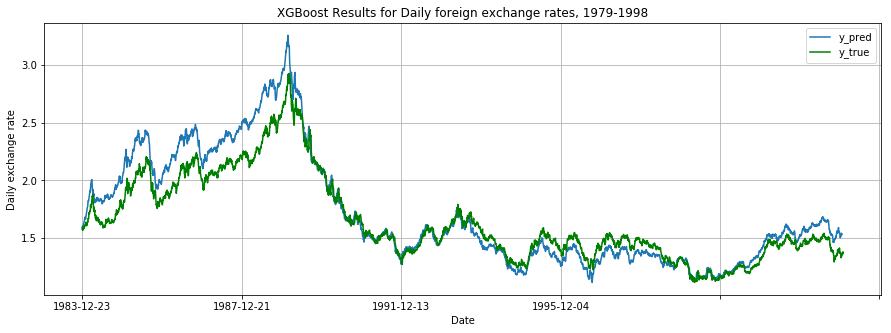

In [161]:
plt.figure(figsize=(15, 5))
y_pred[0].plot(label="y_pred")
df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'].plot(label="y_true", color='green')
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающуей и тестовой выборок
#plt.axvline(x='3580', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Daily foreign exchange rates, 1979-1998')
plt.xlabel('Date')
plt.ylabel('Daily exchange rate')

In [163]:
mse_train = mean_squared_error(df.iloc[30:3580], y_pred[0:3550])
mse_test = mean_squared_error(df.iloc[3580:4774], y_pred[3550:4744])

print('MSE train =' , mse_train)
print('MSE test =', mse_test)

MSE train = 0.0292237276374
MSE test = 0.0074059452745


Ошибка оказалась хуже, чем при изначальном прогнозе, когда целевой переменной было само значение, а не разность. Попробуем обучить алгоритм на старой целевой переменной и новых признаках.

In [164]:
gbm3 = xgb.XGBRegressor()

In [165]:
res = gbm3.fit(dataframe[0:3580], df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'][0:3580])

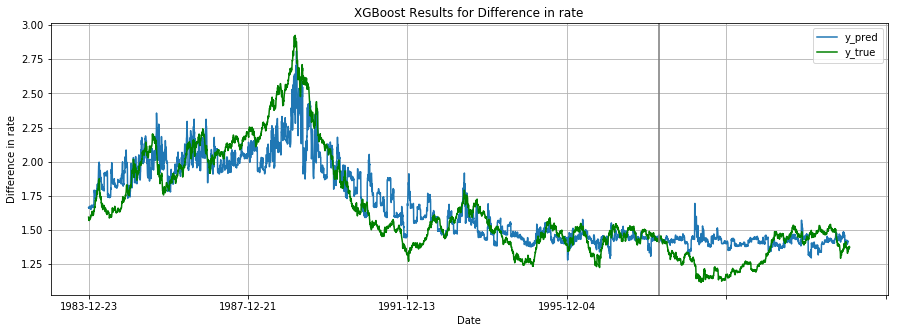

In [166]:
y_pred = pd.DataFrame(data=gbm3.predict(dataframe))
y_pred.index = dataframe.drop('t-0', axis=1).index
style='bmh'

plt.figure(figsize=(15, 5))
plt.title('XGBoost Results for Difference in rate')

pd.Series(y_pred[0]).plot(label='y_pred')
df['Daily foreign exchange rates, 31 December 1979 ? 31 December 1998'].plot(label="y_true", color='green')

plt.axis('tight')
plt.grid(True)
    # линия обозначает границу обучающей и тестовой выборок
plt.axvline(x=3580, color='grey',  linewidth=2, alpha=0.8)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Difference in rate')

In [169]:
mse_train = mean_squared_error(df.iloc[30:3580], y_pred[0:3550])
mse_test = mean_squared_error(df.iloc[3580:4774], y_pred[3550:4744])

print('MSE train =' , mse_train)
print('MSE test =', mse_test)

MSE train = 0.0330154003292
MSE test = 0.0261513747975


In [170]:
xgb.plot_importance(gbm3)

Обобщим резульаты:

| Признаки | Качество на обучении | Качество на контроле
| :- |:-: | :-: | :-:
| $t-2 \text{,  } t-1$, Qs, .... | 0.007764 | 0.003199
|  |  |
| Скользящее среднее | 0.000258
| Завтра как вчера  |  0.000201

### Monthly gambling expenditure in Victoria, Australia, July 1999 to November 2006

In [173]:
df = pd.read_csv('Project TS/monthly-gambling-expenditure-in-.csv', index_col=['Month'], parse_dates=['Month'], error_bad_lines=False)
df.columns = ['Expenditures']
df.head(5)

b'Skipping line 92: expected 2 fields, saw 3\n'


Expenditures
Month                   
1999-07-01          5.81
1999-08-01          5.76
1999-09-01          5.99
1999-10-01          6.12
1999-11-01          6.03

In [174]:
tsplot(df['Expenditures'], lags=50, name='Expenditures')

Критерий Дики-Фуллера
ADF Statistic: -2.217505
p-value: 0.199954
Critical Values:
	5%: -2.900
	1%: -3.519
	10%: -2.587


Построим наивный прогноз, предполагая, что будущее знчение переменной завиист от $n$ её предыдущих значений, следующим образом:

$$\hat{y_t} = \frac{1}{k} \sum_{n=0}^{k-1} y_{t-n},$$

и посчитаем для него среднеквадратичную ошибку.

In [175]:
plotMovingAverage(df['Expenditures'], n=2, name='Expenditures')

In [178]:
print('MSE =' , mean_squared_error(df['Expenditures'][1:70], df['Expenditures'].rolling(window=2).mean()[1:70]))

MSE = 0.0227634057971


In [179]:
plotLag(df['Expenditures'], name='Expenditures')

In [181]:
print('MSE =', mean_squared_error(df['Expenditures'][1:70], pd.Series(df['Expenditures'].shift(periods=1))[1:70]))

MSE = 0.0910536231884


Получили, что при первом прогнозе среднеквадратичная ошибка сильно меньше ($\sim 0.02$). Теперь добавим признаки.

In [182]:
df_features = pd.DataFrame()
for i in range(10,0,-1):
    df_features['t-'+str(i)] = df['Expenditures'].shift(i)
df = pd.concat([df, df_features], axis=1)

df['Month'] = df.index.map(lambda x: x.month)
df = pd.concat([df, pd.get_dummies(df['Month'])], axis=1)
avg = df.groupby(by=df['Month'])['Expenditures'].mean()
df['MonthAvg'] = df.Month.map(lambda x: avg[df['Month'][x-1]])

df['Year'] = df.index.map(lambda x: x.year)
df = pd.concat([df, pd.get_dummies(df['Year'])], axis=1)
avg = df.groupby(by=df['Year'])['Expenditures'].mean()
df['YearAvg'] = df.Year.map(lambda x: avg[x])

df['Quarter'] = df['Month'].map(lambda x: quarter(x))
df = pd.concat([df, pd.get_dummies(df['Quarter'], prefix='Q')], axis=1)

prev1 = pd.DataFrame(df['Expenditures'].values)
shifted1 = prev1.shift(1)
shifted2 = shifted1.shift(1)
average = (shifted1+shifted2)/2
average.index = df.index
average.columns=['Average of prev']
df = pd.concat([df, average], axis=1)


In [183]:
df.head(4)

Expenditures  t-10  t-9  t-8  t-7  t-6  t-5  t-4   t-3   t-2  \
Month                                                                      
1999-07-01          5.81   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   
1999-08-01          5.76   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   
1999-09-01          5.99   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  5.81   
1999-10-01          6.12   NaN  NaN  NaN  NaN  NaN  NaN  NaN  5.81  5.76   

                 ...         2004  2005  2006   YearAvg  Quarter  Q_1  Q_2  \
Month            ...                                                         
1999-07-01       ...            0     0     0  5.993333        3    0    0   
1999-08-01       ...            0     0     0  5.993333        3    0    0   
1999-09-01       ...            0     0     0  5.993333        3    0    0   
1999-10-01       ...            0     0     0  5.993333        4    0    0   

            Q_3  Q_4  Average of prev  
Month                                  
1999-07-01    1    0              NaN  
1999-08-01    1    0              NaN  
1999-09-01    1    0            5.785  
1999-10-01    0    1            5.875  

[4 rows x 41 columns]

In [184]:
gbm = xgb.XGBRegressor(max_depth=5, n_estimators=70)
res = gbm.fit(df[:70].drop('Expenditures', axis=1), df['Expenditures'][:70])

In [186]:
y_pred = pd.DataFrame(data=gbm.predict(df.drop('Expenditures', axis=1)))
y_pred.index = df.drop('Expenditures', axis=1).index
style='bmh'

plt.figure(figsize=(15, 5))
plt.title('XGBoost Results for Expenditures')

pd.Series(y_pred[0]).plot(label='y_pred')
df['Expenditures'].plot(label="y_true", color='green')

plt.axis('tight')
plt.grid(True)
    # линия обозначает границу обучающей и тестовой выборок
plt.axvline(x='2005-04', color='grey',  linewidth=2)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Expenditures')

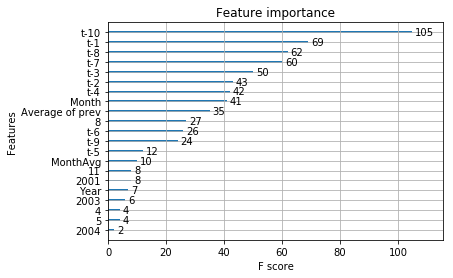

In [187]:
xgb.plot_importance(gbm)

In [188]:
mse_train = mean_squared_error(df['Expenditures'][:70], y_pred[:70])
mse_test = mean_squared_error(df['Expenditures'][70:], y_pred[70:])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.000602676435784
MSE test = 0.0563217668756


In [194]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)
param_test1 = {'n_estimators' : np.arange(50,100,10), 'max_depth': np.arange(2,10,1)}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(), 
                        param_grid = param_test1, scoring=scorer, n_jobs=4, iid=False, cv=5)
gsearch1.fit(df[:70].drop('Expenditures', axis=1), df['Expenditures'][:70])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.12532, std: 0.10680, params: {'max_depth': 2, 'n_estimators': 50},
  mean: -0.12101, std: 0.09145, params: {'max_depth': 2, 'n_estimators': 60},
  mean: -0.11872, std: 0.08257, params: {'max_depth': 2, 'n_estimators': 70},
  mean: -0.11643, std: 0.07871, params: {'max_depth': 2, 'n_estimators': 80},
  mean: -0.11407, std: 0.07522, params: {'max_depth': 2, 'n_estimators': 90},
  mean: -0.11324, std: 0.09962, params: {'max_depth': 3, 'n_estimators': 50},
  mean: -0.10973, std: 0.07980, params: {'max_depth': 3, 'n_estimators': 60},
  mean: -0.10871, std: 0.06932, params: {'max_depth': 3, 'n_estimators': 70},
  mean: -0.10794, std: 0.06634, params: {'max_depth': 3, 'n_estimators': 80},
  mean: -0.10545, std: 0.06286, params: {'max_depth': 3, 'n_estimators': 90},
  mean: -0.12149, std: 0.11519, params: {'max_depth': 4, 'n_estimators': 50},
  mean: -0.11208, std: 0.08702, params: {'max_depth': 4, 'n_estimators': 60},
  mean: -0.10871, std: 0.07493, params: {'max_depth': 4, 'n_esti

Обобщим резульаты:

| Признаки | Качество на обучении | Качество на контроле
| :- |:-: | :-: | :-:
| $t-2 \text{,  } t-1$, Qs, .... | 0.0006 | 0.0563
| Скользящее среднее | 0.0227
| Завтра как вчера  |  0.0910

### Oil prices in constant 1997 dollars. 1870-1997

In [197]:
df = pd.read_csv('Project TS/oil-prices-in-constant-1997-doll.csv', index_col=['Year'], parse_dates=['Year'], error_bad_lines=False)
df['Oil prices in constant 1997 dollars. 1870-1997'] = df['Oil prices in constant 1997 dollars. 1870-1997'].astype(float)
df = df[0:127]
df.head()

Oil prices in constant 1997 dollars. 1870-1997
Year                                                
1870                                           58.53
1871                                           49.09
1872                                           24.68
1873                                           16.71
1874                                           19.86

Критерий Дики-Фуллера
ADF Statistic: -4.663637
p-value: 0.000098
Critical Values:
	5%: -2.885
	1%: -3.484
	10%: -2.579


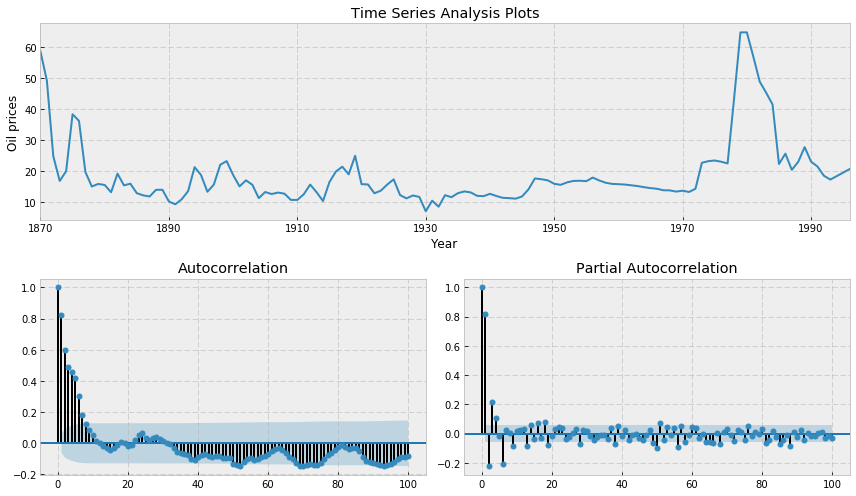

In [198]:
tsplot(df['Oil prices in constant 1997 dollars. 1870-1997'], lags=100, name='Oil prices')

Построим наивный прогноз, предполагая, что будущее знчение переменной завиист от $n$ её предыдущих значений, следующим образом:

$$\hat{y_t} = \frac{1}{k} \sum_{n=0}^{k-1} y_{t-n},$$

и посчитаем для него среднеквадратичную ошибку.

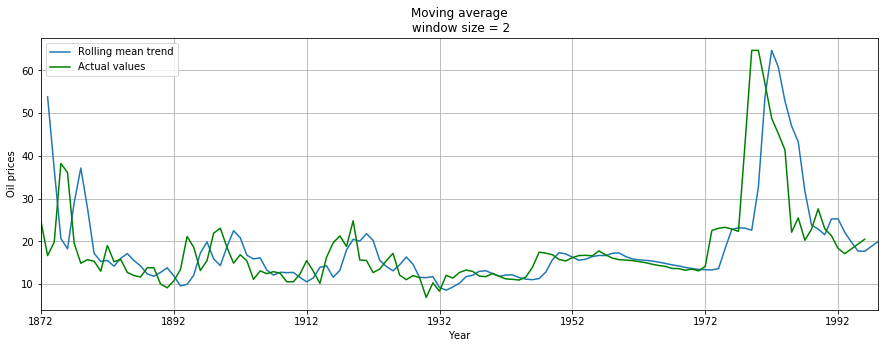

In [199]:
plotMovingAverage(df['Oil prices in constant 1997 dollars. 1870-1997'], n=2, name='Oil prices')

In [202]:
print('MSE =' , mean_squared_error(df['Oil prices in constant 1997 dollars. 1870-1997'][1:100], df['Oil prices in constant 1997 dollars. 1870-1997'].rolling(window=2).mean()[1:100]))

MSE = 5.12745454545


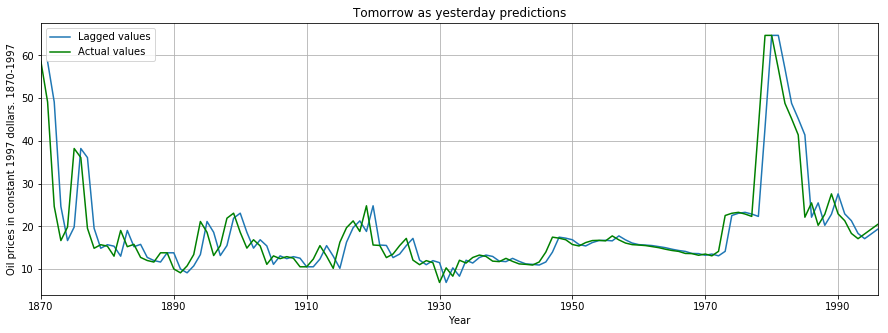

In [203]:
plotLag(df['Oil prices in constant 1997 dollars. 1870-1997'], name='Oil prices in constant 1997 dollars. 1870-1997')

In [205]:
print('MSE =', mean_squared_error(df['Oil prices in constant 1997 dollars. 1870-1997'][1:100], pd.Series(df['Oil prices in constant 1997 dollars. 1870-1997'].shift(periods=1))[1:100]))

MSE = 20.5098181818


Получили, что при первом прогнозе среднеквадратичная ошибка сильно меньше ($\sim 5$). Теперь добавим признаки.

In [206]:
df_features = pd.DataFrame()
for i in range(10,0,-1):
    df_features['t-'+str(i)] = df['Oil prices in constant 1997 dollars. 1870-1997'].shift(i)
df = pd.concat([df, df_features], axis=1)

df['Decade'] = df.index.map(lambda x: (int(x)-1800)/10)
df = pd.concat([df, pd.get_dummies(df['Decade'], prefix='Dec')], axis=1)
avg = df.groupby(by=df['Decade'])['Oil prices in constant 1997 dollars. 1870-1997'].mean()
df['DecAvg'] = df.Decade.map(lambda x: avg[x])

prev1 = pd.DataFrame(df['Oil prices in constant 1997 dollars. 1870-1997'].values)
shifted1 = prev1.shift(1)
shifted2 = shifted1.shift(1)
average = (shifted1+shifted2)/2
average.index = df.index
average.columns=['Average of prev']
df = pd.concat([df, average], axis=1)

In [207]:
gbm3 = xgb.XGBRegressor()
res = gbm3.fit(df[:100].drop('Oil prices in constant 1997 dollars. 1870-1997', axis=1), df['Oil prices in constant 1997 dollars. 1870-1997'][:100])

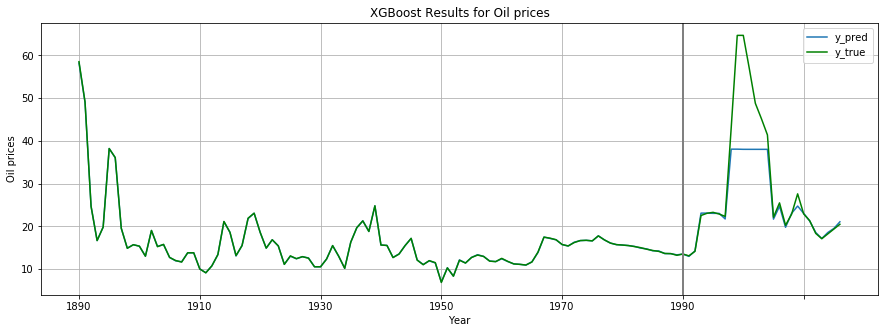

In [209]:
y_pred = pd.DataFrame(data=gbm3.predict(df.drop('Oil prices in constant 1997 dollars. 1870-1997', axis=1)))
y_pred.index = df.drop('Oil prices in constant 1997 dollars. 1870-1997', axis=1).index
style='bmh'

plt.figure(figsize=(15, 5))
plt.title('XGBoost Results for Oil prices')

pd.Series(y_pred[0]).plot(label='y_pred')
df['Oil prices in constant 1997 dollars. 1870-1997'].plot(label="y_true", color='green')

plt.axis('tight')
plt.grid(True)
    # линия обозначает границу обучающей и тестовой выборок
plt.axvline(x=100, color='grey',  linewidth=2)

plt.legend()

plt.xlabel('Year')
plt.ylabel('Oil prices')

Видно, что даже подбирать параметры не имеет смысла. Маловероятно, что XGBoost каким-то образом уловит необъяснимый ни предыдущими значениями, ни каким-либо трендом, скачок в 1980.

In [210]:
xgb.plot_importance(gbm3)

In [211]:
mse_train = mean_squared_error(df['Oil prices in constant 1997 dollars. 1870-1997'][:100], y_pred[:100])
mse_test = mean_squared_error(df['Oil prices in constant 1997 dollars. 1870-1997'][100:], y_pred[100:])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.00282287823468
MSE test = 73.5836170756


Обобщим резульаты:

| Признаки | Качество на обучении | Качество на контроле
| :- |:-: | :-: | :-:
| $t-2 \text{,  } t-1$, Decades, .... | 0.8173 | 391.34
| Скользящее среднее | 5.127
| Завтра как вчера  |  20.50

### IBM common stock closing prices from 29th June 1959 to 30th June 1960 (N = 255)

In [317]:
df_ibm = pd.read_csv('Project TS/ibm-common-stock-closing-prices-.csv', index_col=['Date'], parse_dates=['Date'])
df_ibm.tail()

IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)
Date                                                                                                                   
1960-06-27                                                                            519                              
1960-06-28                                                                            519                              
1960-06-29                                                                            522                              
1960-06-30                                                                            522                              
IBM common stock closing prices: daily           29th June 1959 to 30th June 1960 (N=255)

In [318]:
df_ibm.drop(df_ibm.index[255], inplace=True)

In [319]:
df_ibm.index = pd.to_datetime(df_ibm.index)

In [320]:
df_ibm['IBM common stock closing prices'] = df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'].astype('float')
df_ibm.drop(labels='IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)', axis=1, inplace=True)
df_ibm.head()

IBM common stock closing prices
Date                                       
1959-06-29                            445.0
1959-06-30                            448.0
1959-07-01                            450.0
1959-07-02                            447.0
1959-07-06                            451.0

Нулевая гипотеза о том,что ряд нестационарный, не отвергается так как p-value = 0.966925, тренды местами есть.

Применим наивный прогноз:

In [321]:
df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)']= df_ibm['IBM common stock closing prices'].astype('float')
df_ibm.drop(labels='IBM common stock closing prices', axis=1, inplace=True)
plotMovingAverage(df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'], n=15)
plt.xlabel('Date')
plt.ylabel('IBM common stock closing prices')

Построим ещё один прогноз, предполагая, что значенияе завтра будет таким же, как вчера, и посчитаем для него срднеквадратичную ошибку.

In [322]:
plotLag(df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'])
plt.xlabel('Date')
plt.ylabel('IBM common stock closing prices')

В обоих случая среднеквадратичные ошибки примерно одинаковые

Дальше новые признаки....

In [323]:
temps = pd.DataFrame(df_ibm.values)
dataframe = pd.concat([temps.shift(2), temps], axis=1)
dataframe.columns = ['t-1', 't+1']
dataframe.index = df_ibm.index
temps = pd.DataFrame(df_ibm.values)
shifted = temps.shift(1)
window = shifted.rolling(window=2)
means = window.mean()
means.index = df_ibm.index
dataframe['mean(t-2,t-1)'] = means
print(dataframe.head(10))

              t-1    t+1  mean(t-2,t-1)
Date                                   
1959-06-29    NaN  445.0            NaN
1959-06-30    NaN  448.0            NaN
1959-07-01  445.0  450.0          446.5
1959-07-02  448.0  447.0          449.0
1959-07-06  450.0  451.0          448.5
1959-07-07  447.0  453.0          449.0
1959-07-08  451.0  454.0          452.0
1959-07-09  453.0  454.0          453.5
1959-07-10  454.0  459.0          454.0
1959-07-13  454.0  440.0          456.5


In [324]:
gbm = XGBRegressor()
res = gbm.fit(dataframe[:'1960-05-02'], df_ibm.loc[:'1960-05-02'], eval_metric='rmse')

In [325]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe))
y_pred.index = df_ibm.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", label="y_pred")
plt.plot(df_ibm, alpha=0.8, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x="1960-05-02", color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)')
plt.xlabel('Date')
plt.ylabel('IBM common stock closing prices')

In [326]:
mse_train = mean_squared_error(df_ibm.loc[:'1960-05-02'], y_pred[:'1960-05-02'])
mse_test = mean_squared_error(df_ibm.loc['1960-05-02':], y_pred['1960-05-02':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)#печально

MSE train =  0.063438707709
MSE test = 1530.5996176


In [327]:
xgb.plot_importance(gbm)

In [328]:
df_features = pd.DataFrame()
for i in range(12,0,-1):
    df_features['t-'+str(i)] = df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'].shift(i)
print(df_features.head(13))
dataframe = dataframe[13:]

             t-12   t-11   t-10    t-9    t-8    t-7    t-6    t-5    t-4  \
Date                                                                        
1959-06-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1959-06-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1959-07-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1959-07-02    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1959-07-06    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  445.0   
1959-07-07    NaN    NaN    NaN    NaN    NaN    NaN    NaN  445.0  448.0   
1959-07-08    NaN    NaN    NaN    NaN    NaN    NaN  445.0  448.0  450.0   
1959-07-09    NaN    NaN    NaN    NaN    NaN  445.0  448.0  450.0  447.0   
1959-07-10    NaN    NaN    NaN    NaN  445.0  448.0  450.0  447.0  451.0   
1959-07-13    NaN    NaN    NaN  445.0  448.0  450.0  447.0  451.0  453.0   
1959-07-14    NaN    NaN  445.0  448.0  450.0  447.0  451.0  453.0  454.0   

In [329]:
gbm = XGBRegressor()
res = gbm.fit(df_features[:'1960-05-02'], df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'].loc[:'1960-05-02'])

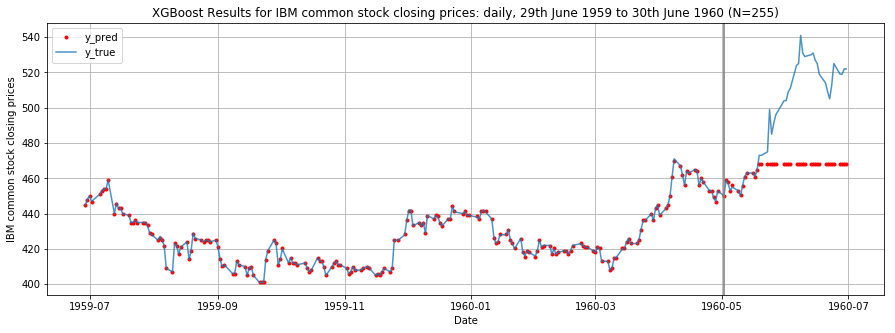

In [330]:
plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", label="y_pred")
plt.plot(df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'], alpha=0.8, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающуей и тестовой выборок
plt.axvline(x="1960-05-02", color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)')
plt.xlabel('Date')
plt.ylabel('IBM common stock closing prices')

In [331]:
mse_train = mean_squared_error(df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'].loc[:'1960-05-02'], y_pred[:'1960-05-02'])
mse_test = mean_squared_error(df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'].loc['1960-05-02':], y_pred['1960-05-02':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)#качество не поменялось, печально :(

MSE train =  0.063438707709
MSE test = 1530.5996176


In [332]:
xgb.plot_importance(gbm)

In [333]:
temps = pd.DataFrame(df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'].values)
df_best_features = pd.concat([temps.shift(12), temps.shift(1)], axis=1)
df_best_features.columns = ['t-12', 't-1']
df_best_features.index = df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'].index
print(df_best_features.head(13))

             t-12    t-1
Date                    
1959-06-29    NaN    NaN
1959-06-30    NaN  445.0
1959-07-01    NaN  448.0
1959-07-02    NaN  450.0
1959-07-06    NaN  447.0
1959-07-07    NaN  451.0
1959-07-08    NaN  453.0
1959-07-09    NaN  454.0
1959-07-10    NaN  454.0
1959-07-13    NaN  459.0
1959-07-14    NaN  440.0
1959-07-15    NaN  446.0
1959-07-16  445.0  443.0


In [334]:
gbm = XGBRegressor()
res = gbm.fit(df_best_features[:'1960-05-02'], df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'].loc[:'1960-05-02'])

In [335]:
y_pred = pd.DataFrame(data=gbm.predict(df_best_features))
y_pred.index = df_ibm.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", label="y_pred")
plt.plot(df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'], alpha=0.8, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающуей и тестовой выборок
plt.axvline(x="1960-05-02", color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)')
plt.xlabel('Date')
plt.ylabel('IBM common stock closing prices')

In [336]:
mse_train = mean_squared_error(df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'].loc[:'1960-05-02'], y_pred[:'1960-05-02'])
mse_test = mean_squared_error(df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'].loc['1960-05-02':], y_pred['1960-05-02':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test) #качество ухудшилось

MSE train =  10.069774717
MSE test = 2610.97878394


In [337]:
df_t_1 = temps.shift(1)
df_t_1.index = df_ibm.index

differenced = pd.DataFrame(data=(df_ibm['IBM common stock closing prices: daily, 29th June 1959 to 30th June 1960 (N=255)'] - df_t_1[0]), index=df_ibm.index )
differenced.columns= ['IBM common stock closing prices']
differenced.head()

IBM common stock closing prices
Date                                       
1959-06-29                              NaN
1959-06-30                              3.0
1959-07-01                              2.0
1959-07-02                             -3.0
1959-07-06                              4.0

In [338]:
differenced.dropna(inplace=True)

Критерий Дики-Фуллера
ADF Statistic: -17.193890
p-value: 0.000000
Critical Values:
	5%: -2.873
	1%: -3.456
	10%: -2.573


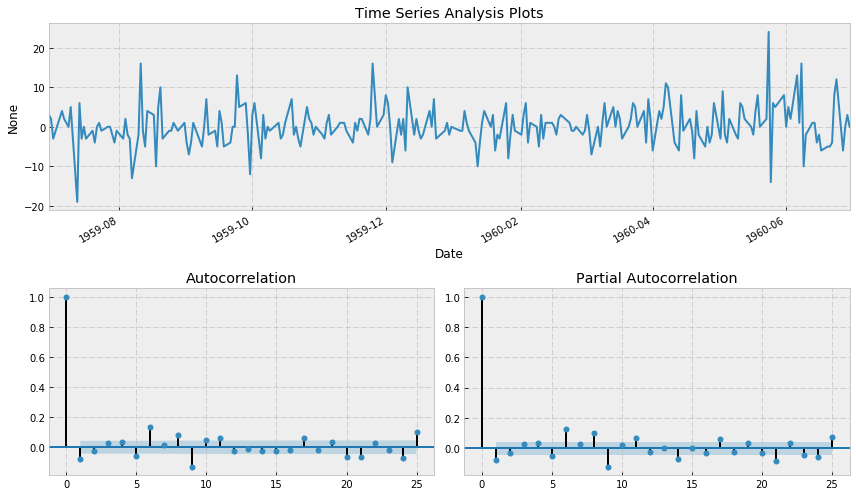

In [339]:
df = differenced
tsplot(differenced['IBM common stock closing prices'], lags=25)

Обобщим результаты:

| Признаки | Качество на обучении | Качество на контроле
| :- |:-: | :-: | :-:
| $t-2 \text{,  } t-1 \text{,   mean}(t-2,t-1)$ | 0.063 | 1530.59
| $ t-12 \text{  } ... \text{  } t-1$ |  0.063 | 1530.5
| $ t-12 \text{,  } t-1$ | 10.06 | 2610.9
|  |  |
| Скользящее среднее | 27.35
| Завтра как вчера  |  25.36

In [117]:

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    
    """
    y - ряд
    lags - количество отрезков на графиках корреляций

    """
    
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        ts_ax.set_xlabel("Date")
        ts_ax.set_ylabel(df.columns[0])
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера")
        result = sm.tsa.stattools.adfuller(y)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
                


        plt.tight_layout()
    return 

def plotMovingAverage(data, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = data.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(data[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    
    MSE_MA = mean_squared_error(data[(n-1):], data.rolling(window=n).mean()[(n-1):])
    
    print('MSE = ', MSE_MA)
    
# завтра будет, как вчера

def plotLag(data):
    
    lag_data = data.shift(periods=1)
    
    plt.figure(figsize=(15,5))
    plt.title("Tomorrow as yesterday predictions")
    plt.plot(lag_data, "g", label="Lagged values")
    
    plt.plot(data, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    
    MSE_lag = mean_squared_error(data[1:], lag_data[1:])
    print('MSE = ', MSE_lag)
    return

### Monthly australian wine sales: thousands of litres (1980 - 1994)

In [118]:
df_wine = pd.read_csv('monthly-australian-wine-sales-th.csv', parse_dates=True, dayfirst=True)
df_wine.drop(df_wine.index[176], inplace=True)
df_wine.head()

Monthly Australian wine sales: thousands of litres. By wine makers in bottles <= 1 litre.
1980-01-01                                            15136.0                                        
1980-02-01                                            16733.0                                        
1980-03-01                                            20016.0                                        
1980-04-01                                            17708.0                                        
1980-05-01                                            18019.0

In [119]:
df_wine.index = pd.to_datetime(df_wine.index)
df_wine['Month'] = df_wine.index.map(lambda x: x.month)

df_wine.columns = ['Monthly wine sale', 'Month']
df_wine['Monthly wine sale'] = df_wine['Monthly wine sale'].astype(float)
df_wine.head()

Monthly wine sale  Month
1980-01-01            15136.0      1
1980-02-01            16733.0      2
1980-03-01            20016.0      3
1980-04-01            17708.0      4
1980-05-01            18019.0      5

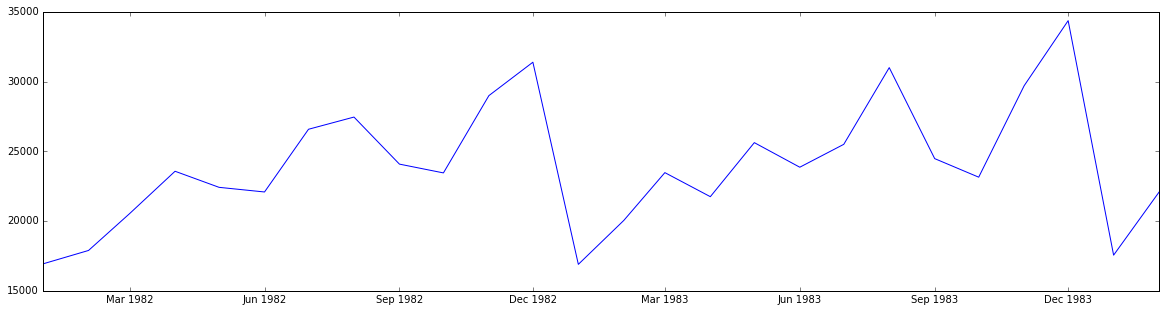

In [120]:
plt.figure(figsize=(20, 5))
plt.plot(df_wine["Monthly wine sale"][24:50])

В данных временных рядах есть сезонность так как люди больше покупают вино к новому году. 

In [121]:
df_wine = pd.concat([df_wine, pd.get_dummies(df_wine['Month'])], axis=1)
df_wine.head()

Monthly wine sale  Month  1  2  3  4  5  6  7  8  9  10  11  12
1980-01-01            15136.0      1  1  0  0  0  0  0  0  0  0   0   0   0
1980-02-01            16733.0      2  0  1  0  0  0  0  0  0  0   0   0   0
1980-03-01            20016.0      3  0  0  1  0  0  0  0  0  0   0   0   0
1980-04-01            17708.0      4  0  0  0  1  0  0  0  0  0   0   0   0
1980-05-01            18019.0      5  0  0  0  0  1  0  0  0  0   0   0   0

In [122]:
avg = df_wine.groupby(by=df_wine['Month'])['Monthly wine sale'].mean()
df_wine['MonthAvg'] = df_wine.Month.map(lambda x: avg[df_wine['Month'][x-1]])

In [123]:
df_wine.head()

Monthly wine sale  Month  1  2  3  4  5  6  7  8  9  10  11  12  \
1980-01-01            15136.0      1  1  0  0  0  0  0  0  0  0   0   0   0   
1980-02-01            16733.0      2  0  1  0  0  0  0  0  0  0   0   0   0   
1980-03-01            20016.0      3  0  0  1  0  0  0  0  0  0   0   0   0   
1980-04-01            17708.0      4  0  0  0  1  0  0  0  0  0   0   0   0   
1980-05-01            18019.0      5  0  0  0  0  1  0  0  0  0   0   0   0   

                MonthAvg  
1980-01-01  17174.400000  
1980-02-01  20366.066667  
1980-03-01  23445.466667  
1980-04-01  24266.000000  
1980-05-01  23594.933333

In [124]:
df_wine.drop(labels='Month', axis=1, inplace=True)

Критерий Дики-Фуллера
ADF Statistic: -2.852468
p-value: 0.051161
Critical Values:
	10%: -2.576
	5%: -2.879
	1%: -3.471


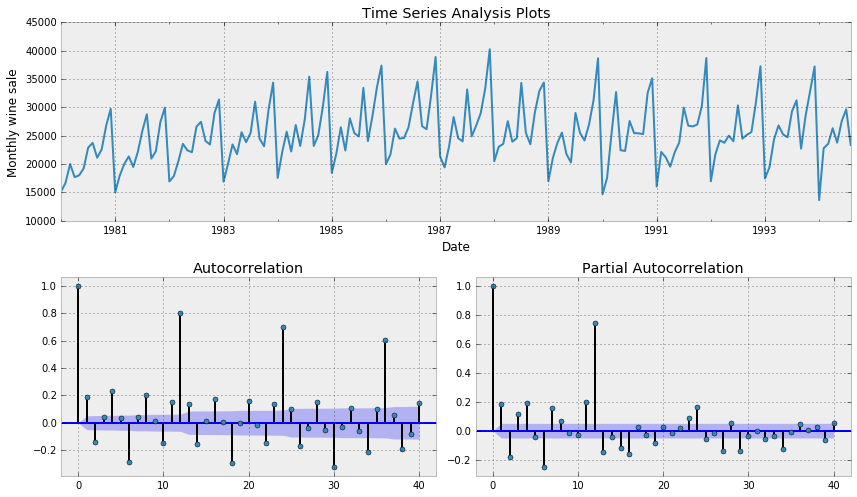

In [125]:
df = df_wine
tsplot(df_wine["Monthly wine sale"], lags=40)

Нулевая гипотеза о том,что ряд нестационарный, не отвергается так как p-value = 0.051(не очень маленкое значение), из автокорреляции видно, что есть сезонность.



Применим наивный прогноз:

In [126]:
plotMovingAverage(df_wine['Monthly wine sale'], n=4)
plt.xlabel('Date')
plt.ylabel('Monthly wine sales')

MSE =  21100464.4541


In [127]:
plotLag(df_wine['Monthly wine sale'])
plt.xlabel('Date')
plt.ylabel('Monthly wine sales')

MSE =  45850198.3657


In [128]:
months_lst = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
dataframe = df_wine[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'MonthAvg']]
dataframe.head()

1  2  3  4  5  6  7  8  9  10  11  12      MonthAvg
1980-01-01  1  0  0  0  0  0  0  0  0   0   0   0  17174.400000
1980-02-01  0  1  0  0  0  0  0  0  0   0   0   0  20366.066667
1980-03-01  0  0  1  0  0  0  0  0  0   0   0   0  23445.466667
1980-04-01  0  0  0  1  0  0  0  0  0   0   0   0  24266.000000
1980-05-01  0  0  0  0  1  0  0  0  0   0   0   0  23594.933333

In [129]:
df_wine.drop(labels=[1, 2, 3, 4, 5 ,6, 7, 8 ,9, 10, 11, 12, 'MonthAvg'], axis=1, inplace=True)

In [130]:
gbm = XGBRegressor()
res = gbm.fit(dataframe[:'1992'], df_wine['Monthly wine sale'].loc[:'1992'])
y_pred = pd.DataFrame(data=gbm.predict(dataframe))
y_pred.index = df_wine.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(df_wine['Monthly wine sale'], label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x='1992', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Monthly wine sale')
plt.xlabel('Year')
plt.ylabel('Monthly wine sales')

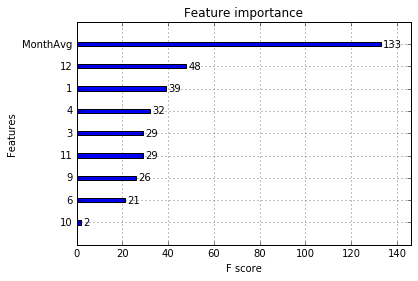

In [131]:
xgb.plot_importance(gbm)

In [132]:
mse_train = mean_squared_error(df_wine.loc[:'1992'], y_pred[:'1992'])
mse_test = mean_squared_error(df_wine.loc['1992':], y_pred['1992':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  7299847.73042
MSE test = 4433995.53402


Получили совсем плохую модель, но это тоже важное знание!(Нет) :)

Теперь добавим лаги (сразу лучшие, поскольку действия ничем не отличаются от предыдущих):

In [133]:
temps = pd.DataFrame(df_wine.values)
mnth = pd.DataFrame(dataframe.values)
dataframe_1 = pd.concat([temps.shift(12), temps.shift(1), mnth], axis=1)
dataframe_1.columns = ['t-12', 't-1', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', 'MonthAvg']
dataframe_1.index = df_wine.index
print(dataframe_1.head(10))

            t-12      t-1   01   02   03   04   05   06   07   08   09   10  \
1980-01-01   NaN      NaN  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1980-02-01   NaN  15136.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1980-03-01   NaN  16733.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1980-04-01   NaN  20016.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1980-05-01   NaN  17708.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1980-06-01   NaN  18019.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1980-07-01   NaN  19227.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
1980-08-01   NaN  22893.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
1980-09-01   NaN  23739.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
1980-10-01   NaN  21133.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   

             11   12      MonthAvg  
1980-01-01  0.0  0.0  17174.400000  
1980-02-01  0.0  0.0  20366.066667  
1980-03-01  0.0  0.

In [134]:
gbm = XGBRegressor()
res = gbm.fit(dataframe_1[:'1992'], df_wine.loc[:'1992'])

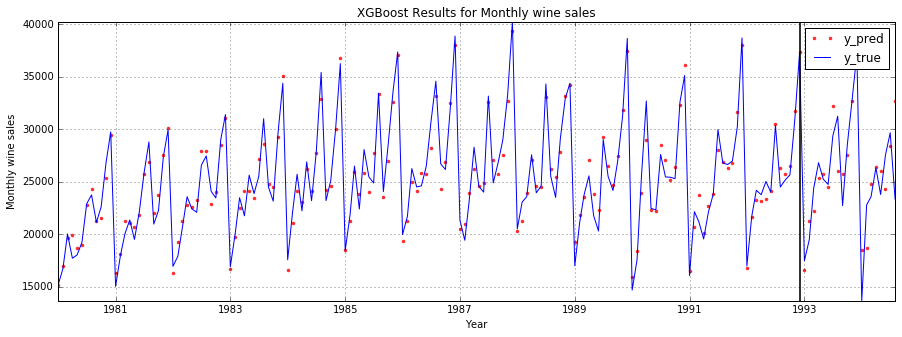

In [135]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe_1))
y_pred.index = df_wine.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(df_wine, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x='1992-12', color='black',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Monthly wine sales')
plt.xlabel('Year')
plt.ylabel('Monthly wine sales')

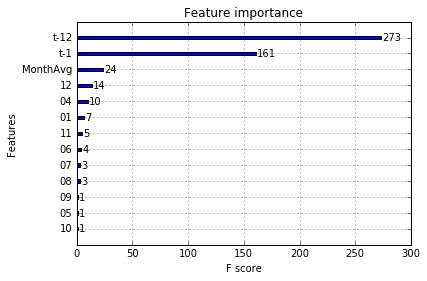

In [136]:
xgb.plot_importance(gbm)

In [137]:
mse_train = mean_squared_error(df_wine.loc[:'1992'], y_pred[:'1992'])
mse_test = mean_squared_error(df_wine.loc['1992':], y_pred['1992':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  1311946.2185
MSE test = 6608200.26699


Стало хуже поэтому уберем

In [138]:
df_t_1 = temps.shift(1)
df_t_1.index = df_wine.index

differenced = pd.DataFrame(data=(df_wine['Monthly wine sale'] - df_t_1[0]), index=df_wine.index )
differenced.columns= ['Monthly wine sale']
differenced.head()

Monthly wine sale
1980-01-01                NaN
1980-02-01             1597.0
1980-03-01             3283.0
1980-04-01            -2308.0
1980-05-01              311.0

In [139]:
differenced.dropna(inplace=True)

Критерий Дики-Фуллера
ADF Statistic: -23.414234
p-value: 0.000000
Critical Values:
	10%: -2.576
	5%: -2.879
	1%: -3.471


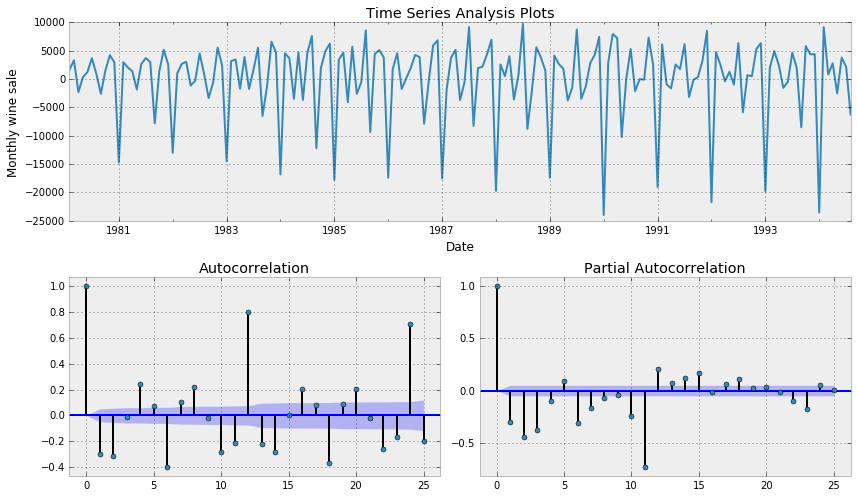

In [140]:
tsplot(differenced['Monthly wine sale'], lags=25)

Временной ряд стационарен.

In [141]:
differenced['Month'] = differenced.index.map(lambda x: x.month)
avg_dif = differenced.groupby(by=differenced['Month'])['Monthly wine sale'].mean()
differenced['MonthAvg'] = differenced.Month.map(lambda x: avg_dif[differenced['Month'][x-1]])

In [142]:
differenced.groupby(by=differenced['Month'])['Monthly wine sale'].mean()

Month
1    -18350.000000
2      3191.666667
3      3079.400000
4       820.533333
5      -671.066667
6       -12.533333
7      4924.000000
8      -402.000000
9     -4230.357143
10     1685.714286
11     4991.571429
12     4779.500000
Name: Monthly wine sale, dtype: float64

In [143]:
differenced.head()

Monthly wine sale  Month     MonthAvg
1980-02-01             1597.0      2  3079.400000
1980-03-01             3283.0      3   820.533333
1980-04-01            -2308.0      4  -671.066667
1980-05-01              311.0      5   -12.533333
1980-06-01             1208.0      6  4924.000000

In [144]:
dataframe_dif = dataframe
dataframe_dif.drop(labels='MonthAvg', axis=1, inplace=True)
dataframe_dif['MthAvg'] = differenced['MonthAvg']
differenced.drop(labels=['Month', 'MonthAvg'], axis=1, inplace=True)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [145]:
temps = pd.DataFrame(differenced.values)
mnth = pd.DataFrame(dataframe_dif.values)
dataframe_diff = pd.concat([temps.shift(3), temps.shift(2), temps.shift(1), mnth], axis=1)
dataframe_diff.columns = ['t-3', 't-2', 't-1', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', 'MonthAvg']
dataframe_diff.index = df_wine.index

In [146]:
dataframe_dif.dropna(inplace=True)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [147]:
dataframe_diff.index = df_wine.index

In [148]:
dataframe_diff.head()

t-3     t-2     t-1   01   02   03   04   05   06   07   08  \
1980-01-01     NaN     NaN     NaN  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1980-02-01     NaN     NaN  1597.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1980-03-01     NaN  1597.0  3283.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1980-04-01  1597.0  3283.0 -2308.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1980-05-01  3283.0 -2308.0   311.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   

             09   10   11   12     MonthAvg  
1980-01-01  0.0  0.0  0.0  0.0          NaN  
1980-02-01  0.0  0.0  0.0  0.0  3079.400000  
1980-03-01  0.0  0.0  0.0  0.0   820.533333  
1980-04-01  0.0  0.0  0.0  0.0  -671.066667  
1980-05-01  0.0  0.0  0.0  0.0   -12.533333

In [149]:
gbm = XGBRegressor()
res = gbm.fit(dataframe_diff["1980-02-01":'1988-04-01'], differenced.loc[:'1988-04-011'])

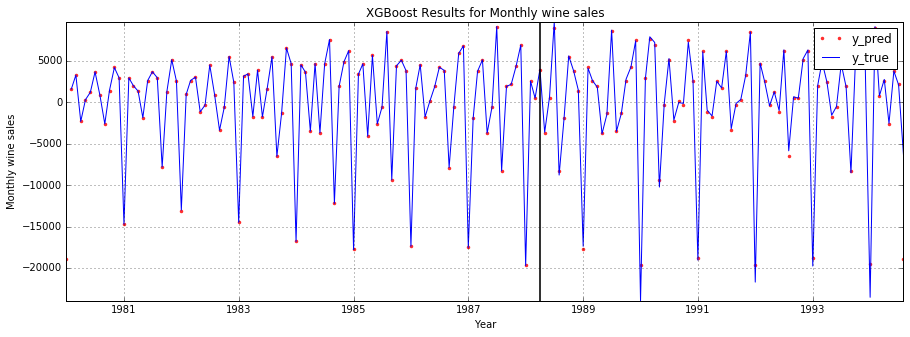

In [150]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe_diff))
y_pred.index = df_wine.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(differenced, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающуей и тестовой выборок
plt.axvline(x='1988-04-01', color='black',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Monthly wine sales')
plt.xlabel('Year')
plt.ylabel('Monthly wine sales')

In [151]:
mse_train = mean_squared_error(differenced.loc["1980-02-01":'1994-04-01'], y_pred["1980-02-01":'1994-04-01'])
mse_test = mean_squared_error(differenced.loc['1994-04-01':], y_pred['1994-04-01':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  255373.112873
MSE test = 31780571.9092


In [152]:
y_pred[1] = [0] * y_pred.shape[0]
y_pred[1]["1980-01-01"] = df_wine['Monthly wine sale']["1980-01-01"]
y_pred.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


0      1
1980-01-01 -18908.664062  15136
1980-02-01   1622.711548      0
1980-03-01   3278.832275      0
1980-04-01  -2301.773193      0
1980-05-01    315.536591      0

In [153]:
# восстановим истинные значени

for i in range(y_pred.shape[0]-1):
    y_pred[1].iloc[i+1] = y_pred[1].iloc[i] + y_pred[0].iloc[i+1]
y_pred.head()

//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0             1
1980-01-01 -18908.664062  15136.000000
1980-02-01   1622.711548  16758.711548
1980-03-01   3278.832275  20037.543823
1980-04-01  -2301.773193  17735.770630
1980-05-01    315.536591  18051.307220

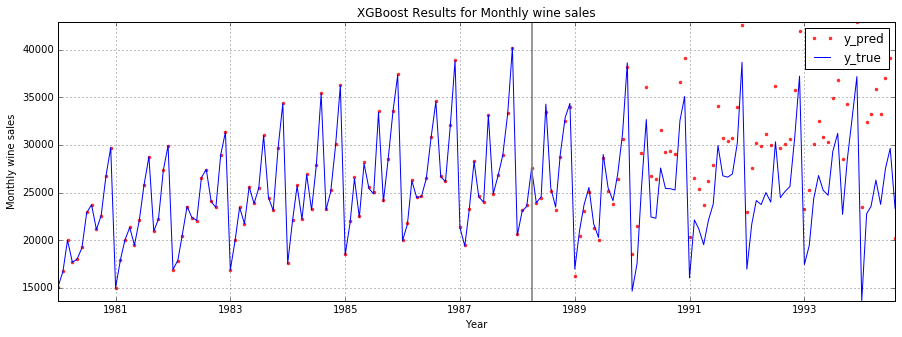

In [154]:
plt.figure(figsize=(15, 5))
plt.plot(y_pred[1], "r.", alpha=0.8, label="y_pred")
plt.plot(df_wine['Monthly wine sale'], label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающуей и тестовой выборок
plt.axvline(x='1988-04-01', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Monthly wine sales')
plt.xlabel('Year')
plt.ylabel('Monthly wine sales')

In [155]:
mse_train = mean_squared_error(df_wine['Monthly wine sale'].loc[:'1994-04-01'], y_pred[1][:'1994-04-01'])
mse_test = mean_squared_error(df_wine['Monthly wine sale'].loc['1994-04-01':], y_pred[1]['1994-04-01':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  8887614.6719
MSE test = 74066605.2907


В итоге получилось:

| Признаки | Качество на обучении | Качество на контроле
| :- |:-: | :-: | :-:
| Самые базовые | 7299847 | 4433995
| С лагами | 1311946 | 6608200
| Без тренда |  8887614 | 74066605
| Скользящее среднее | 11462549
| Завтра как вчера  |  45850198

### Quarterly change in business inventories, 1955-1969

In [156]:
df_inv = pd.read_csv('quarterly-change-in-business-inv.csv')
df_inv.tail()

Quarter  \
56                                             1969Q1   
57                                             1969Q2   
58                                             1969Q3   
59                                             1969Q4   
60  Quarterly change in business inventories (bill...   

    Quarterly change in business inventories (billions) 1955-1969  
56                                                8.3              
57                                               10.2              
58                                               13.3              
59                                                6.2              
60                                                NaN

In [157]:
df_inv.drop(df_inv.index[60], inplace=True)

In [158]:
df_inv.index = pd.to_datetime(df_inv.index)

In [159]:
date_index = pd.date_range(start='1955', end='1970', freq='Q')
df_inv.index = date_index
df_inv.index.name = 'Year'
df_inv['Q'] = df_inv['Quarter'].map(lambda x: x[-1])
df_inv.drop(inplace=True, labels='Quarter', axis=1)
df_inv.columns = ['Change in business inv.', 'Quarter']
df_inv['Change in business inv.'] =  df_inv['Change in business inv.'].astype(float)
df_inv['Quarter'] = df_inv['Quarter'].astype(int)

In [160]:
df_inv = pd.concat([df_inv, pd.get_dummies(df_inv['Quarter'], columns=['Q1', 'Q2', 'Q3', 'Q4'])], axis=1)

In [161]:
df_inv.drop('Quarter', axis=1, inplace=True)

Критерий Дики-Фуллера
ADF Statistic: -1.782978
p-value: 0.388945
Critical Values:
	10%: -2.595
	5%: -2.914
	1%: -3.551


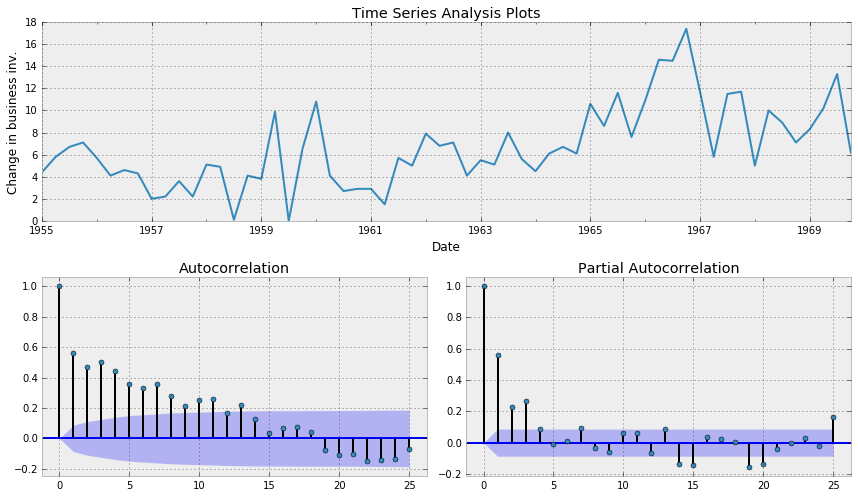

In [162]:
df = df_inv
tsplot(df_inv['Change in business inv.'], lags=25)

Ряд нестационарный

MSE =  7.42013856132


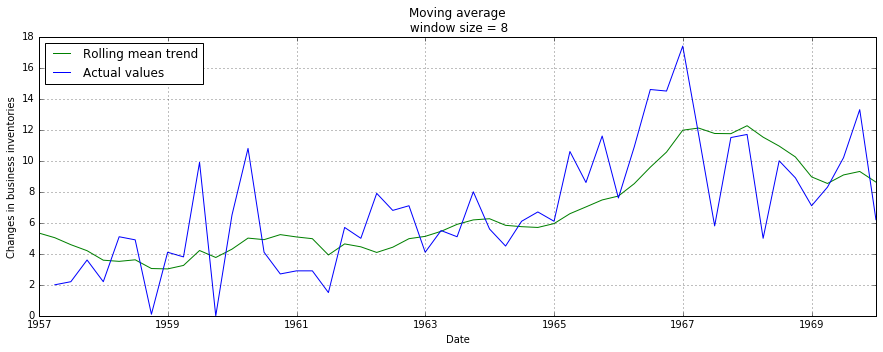

In [163]:
plotMovingAverage(df_inv['Change in business inv.'], n=8)
plt.xlabel('Date')
plt.ylabel('Changes in business inventories')

MSE =  11.6701694915


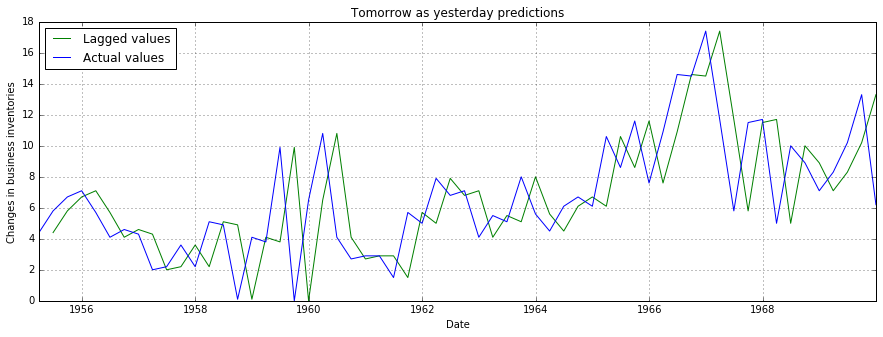

In [164]:
plotLag(df_inv['Change in business inv.'])
plt.xlabel('Date')
plt.ylabel('Changes in business inventories')

In [165]:
temps = pd.DataFrame(df_inv["Change in business inv."].values)
qua = pd.DataFrame(df_inv[[1, 2, 3, 4]].values)
dataframe = pd.concat([temps.shift(12), temps.shift(1), qua], axis=1)
dataframe.columns = ['t-2', 't-1', 'Q1', 'Q2', 'Q3', 'Q4']
dataframe.index = df_inv.index
print(dataframe.head(10))

            t-2  t-1  Q1  Q2  Q3  Q4
Year                                
1955-03-31  NaN  NaN   1   0   0   0
1955-06-30  NaN  4.4   0   1   0   0
1955-09-30  NaN  5.8   0   0   1   0
1955-12-31  NaN  6.7   0   0   0   1
1956-03-31  NaN  7.1   1   0   0   0
1956-06-30  NaN  5.7   0   1   0   0
1956-09-30  NaN  4.1   0   0   1   0
1956-12-31  NaN  4.6   0   0   0   1
1957-03-31  NaN  4.3   1   0   0   0
1957-06-30  NaN  2.0   0   1   0   0


In [166]:
df_inv.drop(labels=[1, 2, 3, 4], axis=1, inplace=True)

In [167]:
gbm = XGBRegressor()
res = gbm.fit(dataframe[:'1964'], df_inv.loc[:'1964'])

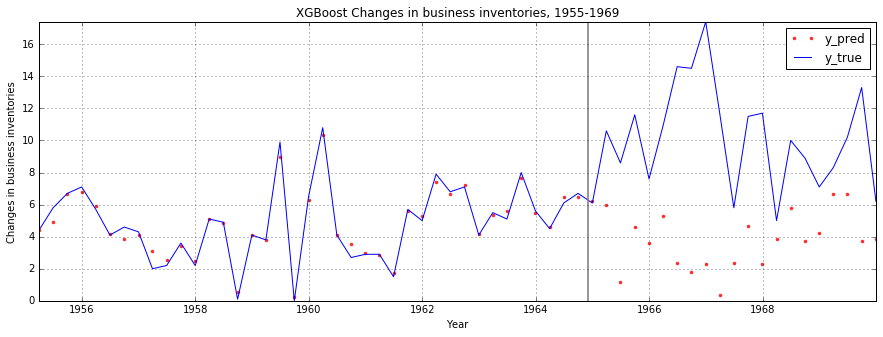

In [168]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe))
y_pred.index = df_inv.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(df_inv, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x='1964-12', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Changes in business inventories, 1955-1969')
plt.xlabel('Year')
plt.ylabel('Changes in business inventories')

In [169]:
mse_train = mean_squared_error(df_inv.loc[:'1964'], y_pred[:'1964'])
mse_test = mean_squared_error(df_inv.loc['1964':], y_pred['1964':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.153505738652
MSE test = 48.0458779195


In [170]:
xgb.plot_importance(gbm)

In [171]:
temps = pd.DataFrame(df_inv['Change in business inv.'].values)
dataframe = pd.concat([temps.shift(12), temps.shift(4), temps.shift(1), qua], axis=1)
dataframe.columns = ['t-12', 't-1', 't-4', 'Q1', 'Q2', 'Q3', 'Q4']
dataframe.index = df_inv.index
print(dataframe.head(13))

            t-12  t-1  t-4  Q1  Q2  Q3  Q4
Year                                      
1955-03-31   NaN  NaN  NaN   1   0   0   0
1955-06-30   NaN  NaN  4.4   0   1   0   0
1955-09-30   NaN  NaN  5.8   0   0   1   0
1955-12-31   NaN  NaN  6.7   0   0   0   1
1956-03-31   NaN  4.4  7.1   1   0   0   0
1956-06-30   NaN  5.8  5.7   0   1   0   0
1956-09-30   NaN  6.7  4.1   0   0   1   0
1956-12-31   NaN  7.1  4.6   0   0   0   1
1957-03-31   NaN  5.7  4.3   1   0   0   0
1957-06-30   NaN  4.1  2.0   0   1   0   0
1957-09-30   NaN  4.6  2.2   0   0   1   0
1957-12-31   NaN  4.3  3.6   0   0   0   1
1958-03-31   4.4  2.0  2.2   1   0   0   0


In [172]:
gbm = XGBRegressor()
res = gbm.fit(dataframe[:'1964'], df_inv.loc[:'1964'], eval_metric='rmse')

In [173]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe))
y_pred.index = df_inv.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(df_inv, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x='1964-12', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Changes in business inventories.')
plt.xlabel('Year')
plt.ylabel('Changes in business inventories')

In [174]:
mse_train = mean_squared_error(df_inv.loc[:'1964'], y_pred[:'1964'])
mse_test = mean_squared_error(df_inv.loc['1964':], y_pred['1964':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.0280545376769
MSE test = 29.7711955685


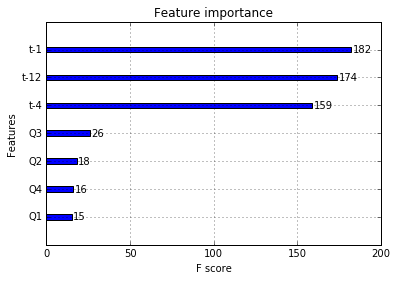

In [175]:
xgb.plot_importance(gbm)

Обобщим резульаты:

| Признаки | Качество на обучении | Качество на контроле
| :- |:-: | :-: | :-:
| $t-2 \text{,  } t-1$, Qs | 0.1535 | 48.0458
| $t-12 \text{,  } t-1 \text{,  } t-4$, Qs | 0.02805| 29.77
|  |  |
| Скользящее среднее | 8.44
| Завтра как вчера  |  11.67

### Annual common stock price USA, 1871 - 1970 

In [177]:
df_stock = pd.read_csv("annual-common-stock-price-us-187.csv", index_col=['Year'], parse_dates=['Year'])
df_stock.head()

Stock price
Year                   
1871-01-01         5.03
1872-01-01         4.80
1873-01-01         4.57
1874-01-01         4.45
1875-01-01         4.06

In [178]:
df_stock['Stock price'] = df_stock["Stock price"].astype(float)

In [179]:
df = df_stock
tsplot(df_stock['Stock price'], lags=25)

Критерий Дики-Фуллера
ADF Statistic: -0.171940
p-value: 0.941785
Critical Values:
	10%: -2.583
	5%: -2.893
	1%: -3.502


Нулевая гипотеза о том,что ряд нестационарный, не отвергается так как p-value = 0.94178, есть тренд к возрастанию.

In [180]:
#наивный прогноз
plotMovingAverage(df_stock['Stock price'], n=4)
plt.ylabel("Year")
plt.xlabel("Stock price")

MSE =  14.7476058594


In [181]:
#значенияе завтра будет таким же, как вчера
plotLag(df_stock['Stock price'])
plt.xlabel("Year")
plt.ylabel("Stock Price")

MSE =  13.2966663265


Получили, что в обоих случаях среднеквадратичные ошибки примерно одинаковы и равны $\sim 14$, однако этот результат сильно зависит от ширины окна в прогнозе скользящего среднего.

Поскольку данные годовые, имеет смысл начать с добавления признака, равного некоторому лагу наблюдений. Здесь попробуем использовать лаги $t-2, t-1$.

In [182]:
temps = pd.DataFrame(df_stock.values)
dataframe = pd.concat([temps.shift(2), temps.shift(1)], axis=1)
dataframe.columns = ['t-2', 't-1']
dataframe.index = df_stock.index
print(dataframe.head(10))

             t-2   t-1
Year                  
1871-01-01   NaN   NaN
1872-01-01   NaN  5.03
1873-01-01  5.03  4.80
1874-01-01  4.80  4.57
1875-01-01  4.57  4.45
1876-01-01  4.45  4.06
1877-01-01  4.06  3.14
1878-01-01  3.14  3.38
1879-01-01  3.38  4.12
1880-01-01  4.12  5.21


In [183]:
#добавим еще и среднее
temps = pd.DataFrame(df_stock.values)
shifted = temps.shift(1)
window = shifted.rolling(window=2)
means = window.mean()
means.index = df_stock.index
dataframe['mean(t-2,t-1)'] = means
print(dataframe.head())

             t-2   t-1  mean(t-2,t-1)
Year                                 
1871-01-01   NaN   NaN            NaN
1872-01-01   NaN  5.03            NaN
1873-01-01  5.03  4.80          4.915
1874-01-01  4.80  4.57          4.685
1875-01-01  4.57  4.45          4.510


In [184]:
gbm = XGBRegressor()
res = gbm.fit(dataframe[:'1933'], df_stock.loc[:'1933'])

In [185]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe))
y_pred.index = df.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", label="y_pred")
plt.plot(df, alpha=0.8, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x="1933", color='black',  linewidth=2, alpha=0.8,ymin = 0,ymax = 80)

plt.legend()
plt.title('XGBoost Results for Annual velocity of money')
plt.xlabel('Year')
plt.ylabel('Annual velocity of money')

In [186]:
mse_train = mean_squared_error(df_stock.loc[:'1933'], y_pred[:'1933'])
mse_test = mean_squared_error(df_stock.loc['1933':], y_pred['1933':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.0779413921938
MSE test = 1545.38054261


In [187]:
xgb.plot_importance(gbm)

In [188]:
df_features = pd.DataFrame()

for i in range(12,0,-1):
    df_features['t-'+str(i)] = df_stock['Stock price'].shift(i)
print(df_features.head(13))
dataframe = dataframe[13:]

            t-12  t-11  t-10   t-9   t-8   t-7   t-6   t-5   t-4   t-3   t-2  \
Year                                                                           
1871-01-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1872-01-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1873-01-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  5.03   
1874-01-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  5.03  4.80   
1875-01-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  5.03  4.80  4.57   
1876-01-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN  5.03  4.80  4.57  4.45   
1877-01-01   NaN   NaN   NaN   NaN   NaN   NaN  5.03  4.80  4.57  4.45  4.06   
1878-01-01   NaN   NaN   NaN   NaN   NaN  5.03  4.80  4.57  4.45  4.06  3.14   
1879-01-01   NaN   NaN   NaN   NaN  5.03  4.80  4.57  4.45  4.06  3.14  3.38   
1880-01-01   NaN   NaN   NaN  5.03  4.80  4.57  4.45  4.06  3.14  3.38  4.12   
1881-01-01   NaN   NaN  5.03  4.80  4.57

In [189]:
gbm = XGBRegressor()
res = gbm.fit(df_features[:'1933'], df_stock['Stock price'].loc[:'1933'])

In [190]:
y_pred = pd.DataFrame(data=gbm.predict(df_features))
y_pred.index = df_stock.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", label="y_pred")
plt.plot(df_stock['Stock price'], alpha=0.8, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x="1933", color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Annual Stock price')
plt.xlabel('Year')
plt.ylabel('Stock price')

In [191]:
mse_train = mean_squared_error(df_stock['Stock price'].loc[:'1933'], y_pred[:'1933'])
mse_test = mean_squared_error(df['Stock price'].loc['1933':], y_pred['1933':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.0162249820355
MSE test = 1340.47011574


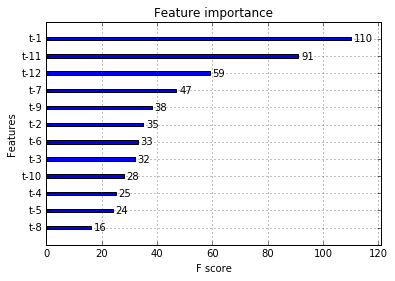

In [192]:
xgb.plot_importance(gbm)

In [193]:
temps = pd.DataFrame(df_stock['Stock price'].values)
df_best_features = pd.concat([temps.shift(12), temps.shift(1)], axis=1)
df_best_features.columns = ['t-12', 't-1']
df_best_features.index = df_stock['Stock price'].index
print(df_best_features.head(13))

            t-12   t-1
Year                  
1871-01-01   NaN   NaN
1872-01-01   NaN  5.03
1873-01-01   NaN  4.80
1874-01-01   NaN  4.57
1875-01-01   NaN  4.45
1876-01-01   NaN  4.06
1877-01-01   NaN  3.14
1878-01-01   NaN  3.38
1879-01-01   NaN  4.12
1880-01-01   NaN  5.21
1881-01-01   NaN  6.25
1882-01-01   NaN  5.90
1883-01-01  5.03  5.63


In [194]:
gbm = XGBRegressor()
res = gbm.fit(df_best_features[:'1933'], df_stock['Stock price'].loc[:'1933'])

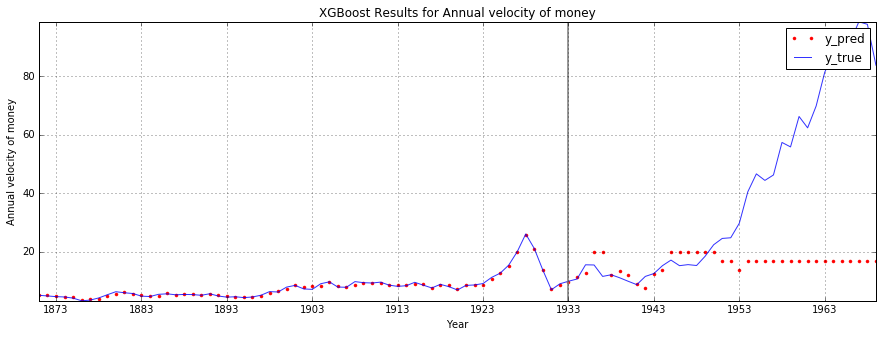

In [195]:
y_pred = pd.DataFrame(data=gbm.predict(df_best_features))
y_pred.index = df_stock.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", label="y_pred")
plt.plot(df_stock['Stock price'], alpha=0.8, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x="1933", color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Annual velocity of money')
plt.xlabel('Year')
plt.ylabel('Annual velocity of money')

In [196]:
mse_train = mean_squared_error(df_stock['Stock price'].loc[:'1933'], y_pred[:'1933'])
mse_test = mean_squared_error(df_stock['Stock price'].loc['1933':], y_pred['1933':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.14753335731
MSE test = 1388.72194906


В итоге получили

| Признаки | Качество на обучении | Качество на контроле
| :- |:-: | :-: | :-:
| $t-2 \text{,  } t-1 \text{,   mean}(t-2,t-1)$ | 0.07794 | 1545.3
| $ t-12 \text{  } ... \text{  } t-1$ | 0.016224 | 1340.4
| $ t-12 \text{,  } t-1$ | 0.14753 | 1388.7
|  |  |
| Скользящее среднее | 14.74
| Завтра как вчера  |  13.29